In [1]:
import sys
#sys.path.insert(0,'/eos/home-a/antoniov/SWAN_projects/env/uproot4/lib/python3.7/site-packages')
sys.path.insert(0,'/eos/home-a/antoniov/SWAN_projects/env/uproot/lib/python3.8/site-packages')
print ( sys.path )

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import mplhep
from matplotlib.colors import LogNorm
from joblib import dump, load
plt.style.use(mplhep.style.CMS)

['/eos/home-a/antoniov/SWAN_projects/env/uproot/lib/python3.8/site-packages', '/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/python', '/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib', '', '/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.8.6-3199b/x86_64-centos7-gcc8-opt/lib/python38.zip', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.8.6-3199b/x86_64-centos7-gcc8-opt/lib/python3.8', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.8.6-3199b/x86_64-centos7-gcc8-opt/lib/python3.8/lib-dynload', '/eos/home-a/antoniov/SWAN_projects/env/uproot/lib/python3.8/site-packages', '/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/IPython/extensions', '/scratch/antoniov/.ipython']


In [2]:
# run_ranges_periods, df_run_ranges, fiducial_cuts, fiducial_cuts_all, aperture_period_map, aperture_parametrisation, check_aperture, get_data, process_data_protons_multiRP
from processing import *

save_figures = False

# test_sample_ratio = 0.40

run_tables = False

Welcome to JupyROOT 6.22/06
{'2017B': 2.360904801, '2017C1': 5.313012839, '2017C2': 3.264135878, '2017D': 4.074723964, '2017E': 8.958810514, '2017F1': 1.708478656, '2017F2': 7.877903151, '2017F3': 3.632463163}
Luminosity: 37.190432966


### Event selection

In [3]:
def select_events( df_events ):
    
    df_events.loc[ :, "deltaPhi_jet_muon"] = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, "muon0_phi"] )
    msk_dphi_ = ( df_events.loc[ :, "deltaPhi_jet_muon"] < -np.pi )
    df_events.loc[ :, "deltaPhi_jet_muon"].loc[ msk_dphi_ ] = df_events.loc[ :, "deltaPhi_jet_muon"].loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( df_events.loc[ :, "deltaPhi_jet_muon"] >= np.pi )
    df_events.loc[ :, "deltaPhi_jet_muon"].loc[ msk_dphi_ ] = df_events.loc[ :, "deltaPhi_jet_muon"].loc[ msk_dphi_ ] - 2*np.pi
    
    df_events.loc[ :, "deltaEta_jet_muon"] = ( df_events.loc[ :, "jet0_eta"] - df_events.loc[ :, "muon0_eta"] )
    df_events.loc[ :, "deltaR_jet_muon"] = np.sqrt( ( df_events.loc[ :, "deltaPhi_jet_muon"] ) ** 2 +
                                                    ( df_events.loc[ :, "deltaEta_jet_muon"] ) ** 2 )
    
    df_events.loc[ :, "deltaPhi_jet_met"] = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, "met_phi"] )
    msk_dphi_ = ( df_events.loc[ :, "deltaPhi_jet_met"] < -np.pi )
    df_events.loc[ :, "deltaPhi_jet_met"].loc[ msk_dphi_ ] = df_events.loc[ :, "deltaPhi_jet_met"].loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( df_events.loc[ :, "deltaPhi_jet_met"] >= np.pi )
    df_events.loc[ :, "deltaPhi_jet_met"].loc[ msk_dphi_ ] = df_events.loc[ :, "deltaPhi_jet_met"].loc[ msk_dphi_ ] - 2*np.pi
    
    df_events.loc[ :, "deltaPhi_jet_Wlep"] = ( df_events.loc[ :, "jet0_phi"] - df_events.loc[ :, "WLeptonicPhi"] )
    msk_dphi_ = ( df_events.loc[ :, "deltaPhi_jet_Wlep"] < -np.pi )
    df_events.loc[ :, "deltaPhi_jet_Wlep"].loc[ msk_dphi_ ] = df_events.loc[ :, "deltaPhi_jet_Wlep"].loc[ msk_dphi_ ] + 2*np.pi
    msk_dphi_ = ( df_events.loc[ :, "deltaPhi_jet_Wlep"] >= np.pi )
    df_events.loc[ :, "deltaPhi_jet_Wlep"].loc[ msk_dphi_ ] = df_events.loc[ :, "deltaPhi_jet_Wlep"].loc[ msk_dphi_ ] - 2*np.pi

    df_events.loc[ :, "jet0_tau21" ] = df_events.loc[ :, "jet0_tau2"] / df_events.loc[ :, "jet0_tau1"]
    
    df_events.loc[ :, "xiCMS_45" ] = ( 1. / 13000 ) * ( df_events.loc[ :, "WLeptonicPt" ] * np.exp( df_events.loc[ :, "WLeptonicEta" ] ) +
                                                        df_events.loc[ :, "jet0_pt" ] * np.exp( df_events.loc[ :, "jet0_eta" ] ) )
    df_events.loc[ :, "xiCMS_56" ] = ( 1. / 13000 ) * ( df_events.loc[ :, "WLeptonicPt" ] * np.exp( -df_events.loc[ :, "WLeptonicEta" ] ) +
                                                        df_events.loc[ :, "jet0_pt" ] * np.exp( -df_events.loc[ :, "jet0_eta" ] ) )

    msk_All_ = np.full( df_events.shape[0], True, dtype=bool )
    msk_muon_ = ( ( df_events.loc[ :, "muon0_pt"] >= 50.0 ) &
                  ( np.abs( df_events.loc[ :, "muon0_eta"] ) <= 2.4 ) & 
                  ( df_events.loc[ :, "muon0_iso"] <= 0.10 ) )
    msk_jet_ = ( ( df_events.loc[ :, "jet0_pt"] >= 200.0 ) &
                 ( np.abs( df_events.loc[ :, "jet0_eta"] ) <= 2.4 ) )
    msk_jet_muon_ = ( df_events.loc[ :, "deltaR_jet_muon"] >= np.pi/2 )
    msk_met_ = ( df_events.loc[ :, "met"] >= 40.0 )
    msk_jet_met_ = ( np.abs( df_events.loc[ :, "deltaPhi_jet_met"] ) >= 2.0 )
    msk_pruned_mass_ = ( ( df_events.loc[ :, "jet0_corrmass"] >= 50.0 ) &
                         ( df_events.loc[ :, "jet0_corrmass"] <= 110.0 ) )
    msk_tau21_       = ( df_events.loc[ :, "jet0_tau21"] <= 0.60 )
    msk_bjet_veto_   = ( df_events.loc[ :, "num_bjets_ak4"] == 0 )
#     msk_xiCMS_ = msk_All_.copy()
    msk_xiCMS_       = ( ( df_events.loc[ :, "xiCMS_45" ] <= 0.20 ) & ( df_events.loc[ :, "xiCMS_56" ] <= 0.20 ) )
    msk_Wlep_ = ( df_events.loc[ :, "WLeptonicPt"] >= 200.0 )
    msk_jet_Wlep_ = ( np.abs( df_events.loc[ :, "deltaPhi_jet_Wlep"] ) >= 2.5 )
    msk_MWW_ = ( df_events.loc[ :, "recoMWW"] >= 500.0 )
    msk_extra_tracks_ = ( df_events.loc[ :, "pfcand_nextracks" ] <= 4 )
#     msk_extra_tracks_ = ( df_events.loc[ :, "pfcand_nextracks" ] <= 999 )
    
    masks_ = [ msk_All_, msk_muon_, msk_jet_, msk_jet_muon_, msk_met_, msk_jet_met_,
               msk_pruned_mass_, msk_tau21_, msk_bjet_veto_, msk_xiCMS_,
               msk_Wlep_, msk_jet_Wlep_, msk_MWW_, msk_extra_tracks_ ]
    selection_keys_ = [ "All", "Muon", "Jet", "Jet_Muon", "MET", "Jet_MET",
                        "PrunedMass", "Tau21", "BJet_Veto", "Xi_CMS",
                        "WLeptonic", "Jet_WLeptonic", "MWW", "ExtraTracks" ]
    selections_ = {}
    msk_ = masks_[ 0 ].copy()
    for idx_, key_ in enumerate( selection_keys_ ):
        msk_ = msk_ & masks_[ idx_ ]
        selections_[ key_ ] = np.sum( msk_ )
        
    df_events = df_events.loc[ msk_ ]
    
    return df_events, selection_keys_, selections_

### Signal

In [4]:
#label = "GGToWW-AQGC-test-A0W1e-6"
#label = "GGToWW-AQGC-test-A0W2e-6"
#label = "GGToWW-AQGC-test-A0W5e-6"
labels_signals = [ "GGToWW-AQGC-A0W1e-6", "GGToWW-AQGC-A0W2e-6", "GGToWW-AQGC-A0W5e-6" ]

# fileNames_signal = [
#     #"output-GGToWW-AQGC-test-A0W1e-6.h5"
#     #"output-GGToWW-AQGC-test-A0W2e-6.h5"
#     "output-GGToWW-AQGC-test-A0W5e-6.h5"
# ]
fileNames_signals = {
    "GGToWW-AQGC-A0W1e-6": [ "output-GGToWW-AQGC-A0W1e-6.h5" ],
    "GGToWW-AQGC-A0W2e-6": [ "output-GGToWW-AQGC-A0W2e-6.h5" ],
    "GGToWW-AQGC-A0W5e-6": [ "output-GGToWW-AQGC-A0W5e-6.h5" ]
    }

df_counts_signals = {}
df_signals_protons_multiRP_index = {}
df_signals_protons_multiRP_events = {}

for label_ in labels_signals:
    import time
    print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
    time_s_ = time.time()

    #df_counts_signal, df_protons_multiRP_signal, df_protons_singleRP_signal, df_ppstracks_signal = 4 * [None]
    #df_protons_multiRP_signal_index, df_protons_multiRP_signal_events, df_ppstracks_signal_index = 3 * [None]

    if run_tables:
        with pd.HDFStore( "reduced-data-store-{}.h5".format( label_ ), complevel=5 ) as store_:

            df_counts_signal_, df_protons_multiRP_signal_, df_protons_singleRP_signal_, df_ppstracks_signal_ = get_data( fileNames_signals[ label_ ] )
            df_protons_multiRP_signal_index_, df_protons_multiRP_signal_events_, df_ppstracks_signal_index_ = process_data_protons_multiRP( df_protons_multiRP_signal_, df_ppstracks_signal_, apply_fiducial=True, within_aperture=True, select_2protons=False, runOnMC=True )

            store_[ "counts" ] = df_counts_signal_
            store_[ "protons_multiRP"] = df_protons_multiRP_signal_index_
            store_[ "events_multiRP" ] = df_protons_multiRP_signal_events_
    
    with pd.HDFStore( "reduced-data-store-{}.h5".format( label_ ), 'r' ) as store_:
        df_counts_signals[ label_ ] = store_[ "counts" ]
        df_signals_protons_multiRP_index[ label_ ] = store_[ "protons_multiRP" ]
        df_signals_protons_multiRP_events[ label_ ] = store_[ "events_multiRP" ]

    time_e_ = time.time()
    print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

2021/05/05 01:41:09
Total time elapsed: 0
2021/05/05 01:41:09
Total time elapsed: 0
2021/05/05 01:41:10
Total time elapsed: 0


In [5]:
label_ = "GGToWW-AQGC-A0W1e-6"
# df_signals_protons_multiRP_index[ label_ ]
df_signals_protons_multiRP_index[ label_ ][ [ 'run_mc', 'crossingAngle', 'period', 'within_aperture' ] ]

run_mc  crossingAngle  period  within_aperture
run lumiblock event  slice                                                
1   2266      226549 0      302030          120.0   2017D             True
              226551 0      305965          120.0  2017F3             True
                     0      305965          120.0  2017F3             True
    2267      226605 0      305178          120.0  2017F2             True
              226690 0      299337          120.0  2017C1             True
    2268      226716 0      305178          150.0  2017F2             True
              226773 0      303435          150.0   2017E             True
    2270      226932 0      297020          130.0   2017B             True
                     0      297020          130.0   2017B             True
    2273      227227 0      305178          130.0  2017F2             True
                     0      305178          130.0  2017F2             True
    2274      227321 0      299337          150.0  2017C1             True
              227328 0      299337          150.0  2017C1             True
              227324 0      303435          150.0   2017E             True
    2275      227457 0      303435          150.0   2017E             True
                     0      303435          150.0   2017E             True
    2276      227546 0      300806          140.0  2017C2             True
                     0      300806          140.0  2017C2             True
              227579 0      303435          140.0   2017E             True
                     0      303435          140.0   2017E             True
    2277      227611 0      299337          130.0  2017C1             True
              227610 0      300806          130.0  2017C2             True
              227661 0      302030          130.0   2017D             True
    2278      227745 0      303435          150.0   2017E             True
    2279      227825 0      299337          130.0  2017C1             True
              227868 0      303435          130.0   2017E             True
    2280      227969 0      303435          120.0   2017E             True
    2282      228117 0      299337          130.0  2017C1             True
                     0      299337          130.0  2017C1             True
              228121 0      299337          130.0  2017C1             True
...                            ...            ...     ...              ...
    9019      401833 0      303435          130.0   2017E             True
              401874 0      299337          130.0  2017C1             True
                     0      299337          130.0  2017C1             True
    9021      402066 0      303435          119.0   2017E             True
                     0      303435          119.0   2017E             True
              402070 0      303435          119.0   2017E             True
              402092 0      303435          119.0   2017E             True
    9024      402306 0      305965          150.0  2017F3             True
              402311 0      302030          150.0   2017D             True
              402331 0      305178          150.0  2017F2             True
              402381 0      302030          150.0   2017D             True
    9026      402504 0      303435          150.0   2017E             True
    9039      403821 0      302030          130.0   2017D             True
    9041      404017 0      297020          130.0   2017B             True
              404092 0      302030          130.0   2017D             True
              404091 0      305178          130.0  2017F2             True
    9042      404200 0      303435          140.0   2017E             True
    9043      404249 0      305178          140.0  2017F2             True
    9049      404804 0      305178          120.0  2017F2             True
              404867 0      299337          120.0  2017C1             True
              404859 0      305178          120.0  20

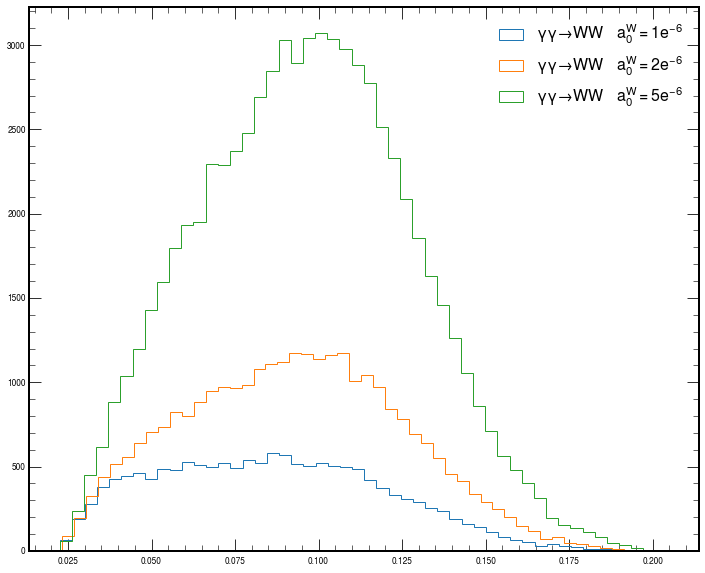

In [6]:
labels_samples = {
    "GGToWW-AQGC-A0W1e-6": r"$\gamma\gamma \to WW \quad a_0^W=1e^{-6}$",
    "GGToWW-AQGC-A0W2e-6": r"$\gamma\gamma \to WW \quad a_0^W=2e^{-6}$",
    "GGToWW-AQGC-A0W5e-6": r"$\gamma\gamma \to WW \quad a_0^W=5e^{-6}$"
}

fig = plt.figure( figsize=(12,10) )
for label_ in labels_signals: 
    plt.hist( df_signals_protons_multiRP_index[ label_ ][ 'xi' ], histtype='step', density=False, bins=50, label=labels_samples[ label_ ] )
plt.legend( loc='best', fontsize=16 )

### Ouf of acceptance protons

In [7]:
# df_signals_protons_multiRP_index_2protons = {}
# df_signals_protons_multiRP_index_1proton_Arm0 = {}
# df_signals_protons_multiRP_index_1proton_Arm1 = {}
# for label_ in labels_signals:
#     print ( label_ )
#     df_protons_multiRP_groupby_arm_ = df_signals_protons_multiRP_index[ label_ ][ [ "arm" ] ].groupby( ["run","lumiblock","event","slice"] )
#     msk_2protons_ = df_protons_multiRP_groupby_arm_[ "arm" ].transform( lambda s_: ( np.sum( s_ == 0 ) >= 1 ) & ( np.sum( s_ == 1 ) >= 1 ) )
#     msk_1proton_Arm0_ = df_protons_multiRP_groupby_arm_[ "arm" ].transform( lambda s_: ( np.sum( s_ == 0 ) >= 1 ) & ( np.sum( s_ == 1 ) == 0 ) )
#     msk_1proton_Arm1_ = df_protons_multiRP_groupby_arm_[ "arm" ].transform( lambda s_: ( np.sum( s_ == 0 ) == 0 ) & ( np.sum( s_ == 1 ) >= 1 ) )
#     print ( msk_2protons_ )
#     print ( msk_1proton_Arm0_ )
#     print ( msk_1proton_Arm1_ )
#     df_signals_protons_multiRP_index_2protons[ label_ ] = df_signals_protons_multiRP_index[ label_ ].loc[ msk_2protons_ ]
#     df_signals_protons_multiRP_index_1proton_Arm0[ label_ ] = df_signals_protons_multiRP_index[ label_ ].loc[ msk_1proton_Arm0_ ]
#     df_signals_protons_multiRP_index_1proton_Arm1[ label_ ] = df_signals_protons_multiRP_index[ label_ ].loc[ msk_1proton_Arm1_ ]

In [8]:
# label_ = "GGToWW-AQGC-A0W1e-6"
# df_signals_protons_multiRP_index_2protons[ label_ ]

In [9]:
# df_signals_protons_multiRP_index_1proton_Arm0[ label_ ]

In [10]:
# df_signals_protons_multiRP_index_1proton_Arm1[ label_ ]

In [11]:
# df_signals_protons_multiRP_index_ = df_signals_protons_multiRP_index_2protons
# # df_signals_protons_multiRP_index_ = df_signals_protons_multiRP_index_1proton_Arm0
# # df_signals_protons_multiRP_index_ = df_signals_protons_multiRP_index_1proton_Arm1
# fig = plt.figure( figsize=(12,10) )
# for label_ in labels_signals: 
#     plt.hist( df_signals_protons_multiRP_index_[ label_ ][ 'xi' ], histtype='step', density=False, bins=50, label=labels_samples[ label_ ] )
# plt.legend( loc='best', fontsize=16 )

### Signal with mixed protons

In [12]:
# run_tables = True

labels_signals_mix_protons = [ "GGToWW-AQGC-mix_protons-A0W1e-6", "GGToWW-AQGC-mix_protons-A0W2e-6", "GGToWW-AQGC-mix_protons-A0W5e-6" ]

fileNames_signals = {
    "GGToWW-AQGC-mix_protons-A0W1e-6": [ "output-GGToWW-AQGC-mix_protons-A0W1e-6.h5" ],
    "GGToWW-AQGC-mix_protons-A0W2e-6": [ "output-GGToWW-AQGC-mix_protons-A0W2e-6.h5" ],
    "GGToWW-AQGC-mix_protons-A0W5e-6": [ "output-GGToWW-AQGC-mix_protons-A0W5e-6.h5" ]
    }

df_counts_signals_mix_protons = {}
df_signals_protons_multiRP_mix_protons_index = {}
df_signals_protons_multiRP_mix_protons_events = {}

for label_ in labels_signals_mix_protons:
    import time
    print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
    time_s_ = time.time()

    #df_counts_signal, df_protons_multiRP_signal, df_protons_singleRP_signal, df_ppstracks_signal = 4 * [None]
    #df_protons_multiRP_signal_index, df_protons_multiRP_signal_events, df_ppstracks_signal_index = 3 * [None]

    if run_tables:
        with pd.HDFStore( "reduced-data-store-{}.h5".format( label_ ), complevel=5 ) as store_:

            df_counts_signal_, df_protons_multiRP_signal_, df_protons_singleRP_signal_, df_ppstracks_signal_ = get_data( fileNames_signals[ label_ ] )
            df_protons_multiRP_signal_index_, df_protons_multiRP_signal_events_, df_ppstracks_signal_index_ = process_data_protons_multiRP( df_protons_multiRP_signal_, df_ppstracks_signal_, apply_fiducial=True, within_aperture=True, mix_protons=True, select_2protons=False, runOnMC=True )

            store_[ "counts" ] = df_counts_signal_
            store_[ "protons_multiRP"] = df_protons_multiRP_signal_index_
            store_[ "events_multiRP" ] = df_protons_multiRP_signal_events_
    
    with pd.HDFStore( "reduced-data-store-{}.h5".format( label_ ), 'r' ) as store_:
        df_counts_signals_mix_protons[ label_ ] = store_[ "counts" ]
        df_signals_protons_multiRP_mix_protons_index[ label_ ] = store_[ "protons_multiRP" ]
        df_signals_protons_multiRP_mix_protons_events[ label_ ] = store_[ "events_multiRP" ]

    time_e_ = time.time()
    print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

2021/05/05 01:41:12
Total time elapsed: 0
2021/05/05 01:41:12
Total time elapsed: 0
2021/05/05 01:41:12
Total time elapsed: 0


In [13]:
label_signal_to_mix_protons = {
     "GGToWW-AQGC-A0W1e-6" : "GGToWW-AQGC-mix_protons-A0W1e-6",
     "GGToWW-AQGC-A0W2e-6" : "GGToWW-AQGC-mix_protons-A0W2e-6",
     "GGToWW-AQGC-A0W5e-6" : "GGToWW-AQGC-mix_protons-A0W5e-6"
}

In [14]:
label_ = "GGToWW-AQGC-A0W1e-6"
df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ]

crossingAngle        xi           thx  \
run lumiblock event  slice                                          
1   2281      228042 0              130.0  0.040710 -1.339373e-05   
                     0              130.0  0.111005 -5.641787e-05   
    2344      234363 0              130.0  0.079774  5.526187e-05   
    4028      402796 0              120.0  0.055434  2.889099e-05   
    4033      403213 0              130.0  0.078802  1.036883e-04   
                     0              130.0  0.105974  5.218447e-05   
    4054      405396 0              150.0  0.077543  6.661195e-05   
    3867      386602 0              140.0  0.076253  8.043599e-05   
    3869      386835 0              140.0  0.110243  5.802389e-06   
    9617      461657 0              150.0  0.058753 -6.249669e-05   
    9624      462379 0              150.0  0.102959 -6.224281e-05   
                     0              150.0  0.090283 -6.088307e-05   
    245       24452  0              150.0  0.060379 -1.941511e-05   
    262       26119  0              150.0  0.098973 -3.174151e-05   
    266       26542  0              120.0  0.053062  9.638428e-05   
    7753      275282 0              150.0  0.095906  9.467000e-06   
    696       69578  0              140.0  0.120754 -9.438089e-05   
                     0              140.0  0.087492 -4.261828e-05   
    1389      138834 0              150.0  0.105080 -8.977557e-05   
    1409      140855 0              130.0  0.075610  9.029261e-06   
    1411      141005 0              150.0  0.054790  5.034913e-06   
    1423      142299 0              150.0  0.118777  8.795727e-05   
    1197      119682 0              140.0  0.043646 -8.447393e-05   
    1237      123633 0              140.0  0.059685  3.656131e-05   
                     0              140.0  0.071542 -1.464423e-05   
    1252      125192 0              130.0  0.063007 -1.922706e-05   
                     0              130.0  0.054396 -8.753509e-05   
    1269      126841 0              120.0  0.086898 -1.266863e-05   
    3559      355893 0              150.0  0.108162 -2.248296e-05   
                     0              150.0  0.114230  4.034511e-05   
...                                   ...       ...           ...   
    6112      111189 0              140.0  0.073071 -3.144582e-05   
    2527      252637 0              150.0  0.076149  2.273445e-04   
    8994      399346 0              130.0  0.040112 -4.912430e-05   
    9078      407790 0              130.0  0.104992  2.666693e-05   
    6192      119191 0              120.0  0.195953 -1.256231e-04   
    6196      119548 0              120.0  0.041619  2.534363e-05   
    5754      75341  0              120.0  0.121904 -2.305167e-06   
    5792      79158  0              130.0  0.068797  3.119822e-05   
    2416      241573 0              120.0  0.042415  4.396395e-05   
                     0              120.0  0.105568 -5.351061e-05   
    2420      241921 0              120.0  0.110685  1.931770e-05   
    6524      152372 0              130.0  0.091100  1.185909e-04   
    6455      145454 0              150.0  0.128582  1.120558e-04   
    2472      247120 0              140.0  0.091241 -2.579187e-05   
    2474      247304 0              150.0  0.054778 -1.668333e-05   
    2511      251017 0              130.0  0.106020  5.678445e-05   
              251046 0              130.0  0.067406 -1.873872e-08   
    2521      252099 0              150.0  0.064491  4.320837e-05   
    6511      151095 0              150.0  0.070216  4.609366e-05   
    9044      404341 0              150.0  0.077421 -2.119775e-05   
    9061      406041 0              130.0  0.078630  4.252567e-05   
    6237      123624 0              130.0  0.059935  4.666689e-05   
    6239      123873 0              150.0  0.072152  4.951709e-05   
    6246      124590 0              140.0  0.107533  4.653825e-06   
    6254      125328 0              150.0  0.107334  6.260812e-05   
    6469      146827 0    

In [15]:
# label_ = "GGToWW-AQGC-A0W1e-6"
# label_mix_protons_ = "GGToWW-AQGC-mix_protons-A0W1e-6"

# df_sig_2protons_ = df_signals_protons_multiRP_index_2protons[ label_ ]
# msk_arm_ = ( df_sig_2protons_.loc[ :, "arm" ] == 0 )
# df_sig_2protons_arm0_ = df_sig_2protons_.loc[ msk_arm_ ]
# index_2protons_arm0_ = df_sig_2protons_arm0_.index
# msk_arm_ = ( df_sig_2protons_.loc[ :, "arm" ] == 1 )
# df_sig_2protons_arm1_ = df_sig_2protons_.loc[ msk_arm_ ]
# index_2protons_arm1_ = df_sig_2protons_arm1_.index

# df_sig_1proton_Arm0_ = df_signals_protons_multiRP_index_1proton_Arm0[ label_ ]
# index_1proton_Arm0_ = df_sig_1proton_Arm0_.index
# df_sig_1proton_Arm1_ = df_signals_protons_multiRP_index_1proton_Arm1[ label_ ]
# index_1proton_Arm1_ = df_sig_1proton_Arm1_.index

# df_mix_ = df_signals_protons_multiRP_mix_protons_index[ label_mix_protons_ ]
# msk_arm_ = ( df_mix_.loc[ :, "arm" ] == 0 )
# df_mix_arm0_ = df_mix_.loc[ msk_arm_ ]
# index_mix_arm0_ = df_mix_arm0_.index
# msk_arm_ = ( df_mix_.loc[ :, "arm" ] == 1 )
# df_mix_arm1_ = df_mix_.loc[ msk_arm_ ]
# index_mix_arm1_ = df_mix_arm1_.index

In [16]:
# msk_sig_1proton_Arm0_mix_arm1_ = index_1proton_Arm0_.isin( index_mix_arm1_ )
# msk_mix_arm1_sig_1proton_Arm0_ = index_mix_arm1_.isin( index_1proton_Arm0_ )
# print ( np.sum( msk_sig_1proton_Arm0_mix_arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_)  )
# df_sig_1proton_Arm0_mix_arm1_ = df_sig_1proton_Arm0_.loc[ msk_sig_1proton_Arm0_mix_arm1_ ]
# df_mix_arm1_sig_1proton_Arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_1proton_Arm0_ ]
# df_1proton_Arm0_mix_Arm1_ = pd.concat( [ df_sig_1proton_Arm0_mix_arm1_, df_mix_arm1_sig_1proton_Arm0_ ] ).sort_index()

# msk_sig_1proton_Arm1_mix_arm0_ = index_1proton_Arm1_.isin( index_mix_arm0_ )
# msk_mix_arm0_sig_1proton_Arm1_ = index_mix_arm0_.isin( index_1proton_Arm1_ )
# print ( np.sum( msk_sig_1proton_Arm1_mix_arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_)  )
# df_sig_1proton_Arm1_mix_arm0_ = df_sig_1proton_Arm1_.loc[ msk_sig_1proton_Arm1_mix_arm0_ ]
# df_mix_arm0_sig_1proton_Arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_1proton_Arm1_ ]
# df_1proton_Arm1_mix_Arm0_ = pd.concat( [ df_sig_1proton_Arm1_mix_arm0_, df_mix_arm0_sig_1proton_Arm1_ ] ).sort_index()

In [17]:
# msk_mix_arm0_sig_2protons_arm0_ = index_mix_arm0_.isin( index_2protons_arm0_ )
# msk_mix_arm0_sig_2protons_arm1_ = index_mix_arm0_.isin( index_2protons_arm1_ )
# msk_mix_arm1_sig_2protons_arm0_ = index_mix_arm1_.isin( index_2protons_arm0_ )
# msk_mix_arm1_sig_2protons_arm1_ = index_mix_arm1_.isin( index_2protons_arm1_ )
# print ( np.sum( msk_mix_arm0_sig_2protons_arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_2protons_arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_2protons_arm0_ ) )
# print ( np.sum( msk_mix_arm1_sig_2protons_arm1_ ) )
# msk_mix_arm0_sig_1proton_Arm0_ = index_mix_arm0_.isin( index_1proton_Arm0_ )
# msk_mix_arm1_sig_1proton_Arm1_ = index_mix_arm1_.isin( index_1proton_Arm1_ )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_)  )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_ ) )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm1_)  )
# msk_mix_arm0_sig_2protons_ = ( msk_mix_arm0_sig_2protons_arm0_ | msk_mix_arm0_sig_2protons_arm1_ )
# msk_mix_arm1_sig_2protons_ = ( msk_mix_arm1_sig_2protons_arm0_ | msk_mix_arm1_sig_2protons_arm1_)
# msk_mix_arm0_ = ( msk_mix_arm0_sig_2protons_ | msk_mix_arm0_sig_1proton_Arm0_ | msk_mix_arm0_sig_1proton_Arm1_ )
# msk_mix_arm1_ = ( msk_mix_arm1_sig_2protons_ | msk_mix_arm1_sig_1proton_Arm0_ | msk_mix_arm1_sig_1proton_Arm1_ )
# print ( np.sum( msk_mix_arm0_ ) )
# print ( np.sum( msk_mix_arm1_ ) )
# print ( np.sum( ~msk_mix_arm0_ ) )
# print ( np.sum( ~msk_mix_arm1_ ) )
# # df_mix_arm0_sig_0protons_ = df_mix_arm0_.loc[ ~msk_mix_arm0_ ]
# # df_mix_arm1_sig_0protons_ = df_mix_arm1_.loc[ ~msk_mix_arm1_ ]

In [18]:
# msk_sig_2protons_arm0_mix_arm1_ = index_2protons_arm0_.isin( index_mix_arm1_ )
# msk_sig_2protons_arm1_mix_arm1_ = index_2protons_arm1_.isin( index_mix_arm1_ )
# print ( np.sum( msk_sig_2protons_arm0_mix_arm1_ ) )
# print ( np.sum( msk_sig_2protons_arm1_mix_arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_2protons_arm0_ ) )
# msk_sig_2protons_arm1_mix_arm0_ = index_2protons_arm1_.isin( index_mix_arm0_ )
# msk_sig_2protons_arm0_mix_arm0_ = index_2protons_arm0_.isin( index_mix_arm0_ )
# print ( np.sum( msk_sig_2protons_arm1_mix_arm0_ ) )
# print ( np.sum( msk_sig_2protons_arm0_mix_arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_2protons_arm1_ ) )
# df_sig_2protons_arm0_mix_arm1_ = df_sig_2protons_arm0_.loc[ msk_sig_2protons_arm0_mix_arm1_ ]
# df_sig_2protons_arm1_mix_arm1_ = df_sig_2protons_arm1_.loc[ msk_sig_2protons_arm1_mix_arm1_ ]
# df_mix_arm1_sig_2protons_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_2protons_ ]
# # df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_.loc[ df_sig_2protons_arm0_mix_arm1_.index ].loc[ :, "eff_proton_all_weighted" ] )
# # df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ]
# df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] )
# df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ]
# df_2protons_Arm0_mix_Arm1_ = pd.concat( [ df_sig_2protons_arm0_mix_arm1_, df_mix_arm1_sig_2protons_arm0_ ] ).sort_index()
# df_sig_2protons_arm1_mix_arm0_ = df_sig_2protons_arm1_.loc[ msk_sig_2protons_arm1_mix_arm0_ ]
# df_sig_2protons_arm0_mix_arm0_ = df_sig_2protons_arm0_.loc[ msk_sig_2protons_arm0_mix_arm0_ ]
# df_mix_arm0_sig_2protons_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_2protons_arm1_ ]
# # df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_.loc[ df_sig_2protons_arm1_mix_arm0_.index ].loc[ :, "eff_proton_all_weighted" ] )
# # df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ]
# df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] )
# df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ]
# df_2protons_Arm1_mix_Arm0_ = pd.concat( [ df_sig_2protons_arm1_mix_arm0_, df_mix_arm0_sig_2protons_arm1_ ] ).sort_index()

In [19]:
# msk_mix_arm0_arm1_ = index_mix_arm0_.isin( index_mix_arm1_ )
# msk_mix_arm1_arm0_ = index_mix_arm1_.isin( index_mix_arm0_ )
# msk_sig_1proton_Arm0_mix_arm0_ = index_1proton_Arm0_.isin( index_mix_arm0_ )
# print ( np.sum( msk_mix_arm0_arm1_ ) )
# print ( np.sum( msk_mix_arm1_arm0_ ) )
# print ( np.sum( msk_sig_1proton_Arm0_mix_arm0_ ) )
# print ( np.sum( msk_sig_1proton_Arm0_mix_arm0_ & msk_sig_1proton_Arm0_mix_arm1_ ) )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm0_ & msk_mix_arm0_arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_ ) )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_ & msk_mix_arm1_arm0_ ) )
# df_sig_1proton_Arm0_mix_arm0_arm1_ = df_sig_1proton_Arm0_.loc[ msk_sig_1proton_Arm0_mix_arm0_ & msk_sig_1proton_Arm0_mix_arm1_ ]
# df_mix_arm0_sig_1proton_Arm0_mix_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_1proton_Arm0_ & msk_mix_arm0_arm1_ ]
# df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_1proton_Arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all_weighted" ] )
# df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_proton_all_weighted" ]
# df_mix_arm1_sig_1proton_Arm0_mix_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_1proton_Arm0_ & msk_mix_arm1_arm0_ ]
# df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = 1.0
# df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_all_weighted" ] = 1.0
# df_1proton_Arm0_mix_Arm0_Arm1_ = pd.concat( [ df_mix_arm0_sig_1proton_Arm0_mix_arm1_, df_mix_arm1_sig_1proton_Arm0_mix_arm0_ ] ).sort_index()

In [20]:
# msk_sig_1proton_Arm1_mix_arm1_ = index_1proton_Arm1_.isin( index_mix_arm1_ )
# print ( np.sum( msk_sig_1proton_Arm1_mix_arm1_ ) )
# print ( np.sum( msk_sig_1proton_Arm1_mix_arm1_ & msk_sig_1proton_Arm1_mix_arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_ ) )
# print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_ & msk_mix_arm0_arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_1proton_Arm1_ & msk_mix_arm1_arm0_ ) )
# df_sig_1proton_Arm1_mix_arm1_arm0_ = df_sig_1proton_Arm1_.loc[ msk_sig_1proton_Arm1_mix_arm1_ & msk_sig_1proton_Arm1_mix_arm0_ ]
# df_mix_arm0_sig_1proton_Arm1_mix_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_1proton_Arm1_ & msk_mix_arm0_arm1_ ]
# df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = 1.0
# df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_all_weighted" ] = 1.0
# df_mix_arm1_sig_1proton_Arm1_mix_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_1proton_Arm1_ & msk_mix_arm1_arm0_ ]
# df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_1proton_Arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all_weighted" ] )
# df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_proton_all_weighted" ]
# df_1proton_Arm1_mix_Arm1_Arm0_ = pd.concat( [ df_mix_arm0_sig_1proton_Arm1_mix_arm1_, df_mix_arm1_sig_1proton_Arm1_mix_arm0_ ] ).sort_index()

In [21]:
# print ( np.sum( msk_sig_2protons_arm0_mix_arm0_ ) )
# print ( np.sum( msk_sig_2protons_arm0_mix_arm0_ & msk_sig_2protons_arm0_mix_arm1_ ) )
# print ( np.sum( msk_sig_2protons_arm1_mix_arm1_ ) )
# print ( np.sum( msk_sig_2protons_arm1_mix_arm1_ & msk_sig_2protons_arm1_mix_arm0_ ) )
# print ( np.sum( msk_mix_arm0_sig_2protons_ ) )
# print ( np.sum( msk_mix_arm0_sig_2protons_ & msk_mix_arm0_arm1_ ) )
# print ( np.sum( msk_mix_arm1_sig_2protons_ ) )
# print ( np.sum( msk_mix_arm1_sig_2protons_ & msk_mix_arm1_arm0_ ) )
# df_sig_2protons_arm0_mix_arm0_arm1_ = df_sig_2protons_arm0_.loc[ msk_sig_2protons_arm0_mix_arm0_ & msk_sig_2protons_arm0_mix_arm1_ ]
# df_sig_2protons_arm1_mix_arm1_arm0_ = df_sig_2protons_arm1_.loc[ msk_sig_2protons_arm1_mix_arm1_ & msk_sig_2protons_arm1_mix_arm0_ ]
# df_mix_arm0_sig_2protons_mix_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_2protons_ & msk_mix_arm0_arm1_ ]
# df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all_weighted" ] )
# df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_proton_all_weighted" ]
# df_mix_arm1_sig_2protons_mix_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_2protons_ & msk_mix_arm1_arm0_ ]
# df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all_weighted" ] )
# df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_proton_all_weighted" ]
# df_2protons_mix_Arm0_Arm1 = pd.concat( [ df_mix_arm0_sig_2protons_mix_arm1_, df_mix_arm1_sig_2protons_mix_arm0_ ] ).sort_index()

In [22]:
# def concatenate_sig_mix( label_, label_mix_protons_ ):
#     df_sig_2protons_ = df_signals_protons_multiRP_index_2protons[ label_ ]
#     msk_arm_ = ( df_sig_2protons_.loc[ :, "arm" ] == 0 )
#     df_sig_2protons_arm0_ = df_sig_2protons_.loc[ msk_arm_ ]
#     index_2protons_arm0_ = df_sig_2protons_arm0_.index
#     msk_arm_ = ( df_sig_2protons_.loc[ :, "arm" ] == 1 )
#     df_sig_2protons_arm1_ = df_sig_2protons_.loc[ msk_arm_ ]
#     index_2protons_arm1_ = df_sig_2protons_arm1_.index

#     df_sig_1proton_Arm0_ = df_signals_protons_multiRP_index_1proton_Arm0[ label_ ]
#     index_1proton_Arm0_ = df_sig_1proton_Arm0_.index
#     df_sig_1proton_Arm1_ = df_signals_protons_multiRP_index_1proton_Arm1[ label_ ]
#     index_1proton_Arm1_ = df_sig_1proton_Arm1_.index

#     df_mix_ = df_signals_protons_multiRP_mix_protons_index[ label_mix_protons_ ]
#     msk_arm_ = ( df_mix_.loc[ :, "arm" ] == 0 )
#     df_mix_arm0_ = df_mix_.loc[ msk_arm_ ]
#     index_mix_arm0_ = df_mix_arm0_.index
#     msk_arm_ = ( df_mix_.loc[ :, "arm" ] == 1 )
#     df_mix_arm1_ = df_mix_.loc[ msk_arm_ ]
#     index_mix_arm1_ = df_mix_arm1_.index
    
#     # 1 proton in Arm 0, mix in Arm 1
#     msk_sig_1proton_Arm0_mix_arm1_ = index_1proton_Arm0_.isin( index_mix_arm1_ )
#     msk_mix_arm1_sig_1proton_Arm0_ = index_mix_arm1_.isin( index_1proton_Arm0_ )
#     print ( np.sum( msk_sig_1proton_Arm0_mix_arm1_ ) )
#     print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_)  )
#     df_sig_1proton_Arm0_mix_arm1_ = df_sig_1proton_Arm0_.loc[ msk_sig_1proton_Arm0_mix_arm1_ ]
#     df_mix_arm1_sig_1proton_Arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_1proton_Arm0_ ]
#     df_mix_arm1_sig_1proton_Arm0_.loc[ :, "eff_proton_all" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_.loc[ :, "eff_proton_all_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_1proton_Arm0_mix_Arm1_ = pd.concat( [ df_sig_1proton_Arm0_mix_arm1_, df_mix_arm1_sig_1proton_Arm0_ ] ).sort_index()
    
#     # 1 proton in Arm 1, mix in Arm 0
#     msk_sig_1proton_Arm1_mix_arm0_ = index_1proton_Arm1_.isin( index_mix_arm0_ )
#     msk_mix_arm0_sig_1proton_Arm1_ = index_mix_arm0_.isin( index_1proton_Arm1_ )
#     print ( np.sum( msk_sig_1proton_Arm1_mix_arm0_ ) )
#     print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_)  )
#     df_sig_1proton_Arm1_mix_arm0_ = df_sig_1proton_Arm1_.loc[ msk_sig_1proton_Arm1_mix_arm0_ ]
#     df_mix_arm0_sig_1proton_Arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_1proton_Arm1_ ]
#     df_mix_arm0_sig_1proton_Arm1_.loc[ :, "eff_proton_all" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_.loc[ :, "eff_proton_all_weighted" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_1proton_Arm1_mix_Arm0_ = pd.concat( [ df_sig_1proton_Arm1_mix_arm0_, df_mix_arm0_sig_1proton_Arm1_ ] ).sort_index()
    
#     # 0 protons
#     msk_mix_arm0_sig_2protons_arm0_ = index_mix_arm0_.isin( index_2protons_arm0_ )
#     msk_mix_arm0_sig_2protons_arm1_ = index_mix_arm0_.isin( index_2protons_arm1_ )
#     msk_mix_arm1_sig_2protons_arm0_ = index_mix_arm1_.isin( index_2protons_arm0_ )
#     msk_mix_arm1_sig_2protons_arm1_ = index_mix_arm1_.isin( index_2protons_arm1_ )
#     print ( np.sum( msk_mix_arm0_sig_2protons_arm0_ ) )
#     print ( np.sum( msk_mix_arm0_sig_2protons_arm1_ ) )
#     print ( np.sum( msk_mix_arm1_sig_2protons_arm0_ ) )
#     print ( np.sum( msk_mix_arm1_sig_2protons_arm1_ ) )
#     msk_mix_arm0_sig_1proton_Arm0_ = index_mix_arm0_.isin( index_1proton_Arm0_ )
#     msk_mix_arm1_sig_1proton_Arm1_ = index_mix_arm1_.isin( index_1proton_Arm1_ )
#     print ( np.sum( msk_mix_arm0_sig_1proton_Arm0_ ) )
#     print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_)  )
#     print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_ ) )
#     print ( np.sum( msk_mix_arm1_sig_1proton_Arm1_)  )
#     msk_mix_arm0_sig_2protons_ = ( msk_mix_arm0_sig_2protons_arm0_ | msk_mix_arm0_sig_2protons_arm1_ )
#     msk_mix_arm1_sig_2protons_ = ( msk_mix_arm1_sig_2protons_arm0_ | msk_mix_arm1_sig_2protons_arm1_)
#     msk_mix_arm0_ = ( msk_mix_arm0_sig_2protons_ | msk_mix_arm0_sig_1proton_Arm0_ | msk_mix_arm0_sig_1proton_Arm1_ )
#     msk_mix_arm1_ = ( msk_mix_arm1_sig_2protons_ | msk_mix_arm1_sig_1proton_Arm0_ | msk_mix_arm1_sig_1proton_Arm1_ )
#     print ( np.sum( msk_mix_arm0_ ) )
#     print ( np.sum( msk_mix_arm1_ ) )
#     print ( np.sum( ~msk_mix_arm0_ ) )
#     print ( np.sum( ~msk_mix_arm1_ ) )
#     df_mix_arm0_sig_0protons_ = df_mix_arm0_.loc[ ~msk_mix_arm0_ ]
#     df_mix_arm1_sig_0protons_ = df_mix_arm1_.loc[ ~msk_mix_arm1_ ]   
#     df_0protons_mix_Arm0_Arm1_ = pd.concat( [ df_mix_arm0_sig_0protons_, df_mix_arm1_sig_0protons_ ] ).sort_index()
#     df_0protons_mix_Arm0_Arm1_.loc[ :, "eff_proton_all" ] = 1.0
#     df_0protons_mix_Arm0_Arm1_.loc[ :, "eff_multitrack" ] = 1.0
#     df_0protons_mix_Arm0_Arm1_.loc[ :, "eff_strictzero" ] = 1.0
#     df_0protons_mix_Arm0_Arm1_.loc[ :, "eff_proton_all_weighted" ] = 1.0
#     df_0protons_mix_Arm0_Arm1_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_0protons_mix_Arm0_Arm1_.loc[ :, "eff_strictzero_weighted" ] = 1.0

#     # 2 protons, 1 misreconstructed
#     msk_sig_2protons_arm0_mix_arm1_ = index_2protons_arm0_.isin( index_mix_arm1_ )
#     msk_sig_2protons_arm1_mix_arm1_ = index_2protons_arm1_.isin( index_mix_arm1_ )
#     print ( np.sum( msk_sig_2protons_arm0_mix_arm1_ ) )
#     print ( np.sum( msk_sig_2protons_arm1_mix_arm1_ ) )
#     print ( np.sum( msk_mix_arm1_sig_2protons_arm0_ ) )
#     msk_sig_2protons_arm1_mix_arm0_ = index_2protons_arm1_.isin( index_mix_arm0_ )
#     msk_sig_2protons_arm0_mix_arm0_ = index_2protons_arm0_.isin( index_mix_arm0_ )
#     print ( np.sum( msk_sig_2protons_arm1_mix_arm0_ ) )
#     print ( np.sum( msk_sig_2protons_arm0_mix_arm0_ ) )
#     print ( np.sum( msk_mix_arm0_sig_2protons_arm1_ ) )
#     df_sig_2protons_arm0_mix_arm1_ = df_sig_2protons_arm0_.loc[ msk_sig_2protons_arm0_mix_arm1_ ]
#     df_sig_2protons_arm1_mix_arm1_ = df_sig_2protons_arm1_.loc[ msk_sig_2protons_arm1_mix_arm1_ ]
#     df_mix_arm1_sig_2protons_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_2protons_ ]
# #     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_.loc[ df_sig_2protons_arm0_mix_arm1_.index ].loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ]
# #     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ]
#     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_.loc[ :, "eff_proton_all" ] )
#     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] )
#     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm1_sig_2protons_arm0_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_2protons_Arm0_mix_Arm1_ = pd.concat( [ df_sig_2protons_arm0_mix_arm1_, df_mix_arm1_sig_2protons_arm0_ ] ).sort_index()
#     df_sig_2protons_arm1_mix_arm0_ = df_sig_2protons_arm1_.loc[ msk_sig_2protons_arm1_mix_arm0_ ]
#     df_sig_2protons_arm0_mix_arm0_ = df_sig_2protons_arm0_.loc[ msk_sig_2protons_arm0_mix_arm0_ ]
#     df_mix_arm0_sig_2protons_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_2protons_arm1_ ]
# #     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_.loc[ df_sig_2protons_arm1_mix_arm0_.index ].loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ]
# #     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ]
#     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_.loc[ :, "eff_proton_all" ] )
#     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] )
#     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm0_sig_2protons_arm1_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_2protons_Arm1_mix_Arm0_ = pd.concat( [ df_sig_2protons_arm1_mix_arm0_, df_mix_arm0_sig_2protons_arm1_ ] ).sort_index()

#     # 1 proton in Arm 0 misreconstructed, mix in Arm 1
#     msk_mix_arm0_arm1_ = index_mix_arm0_.isin( index_mix_arm1_ )
#     msk_mix_arm1_arm0_ = index_mix_arm1_.isin( index_mix_arm0_ )
#     msk_sig_1proton_Arm0_mix_arm0_ = index_1proton_Arm0_.isin( index_mix_arm0_ )
#     print ( np.sum( msk_mix_arm0_arm1_ ) )
#     print ( np.sum( msk_mix_arm1_arm0_ ) )
#     print ( np.sum( msk_sig_1proton_Arm0_mix_arm0_ ) )
#     print ( np.sum( msk_sig_1proton_Arm0_mix_arm0_ & msk_sig_1proton_Arm0_mix_arm1_ ) )
#     print ( np.sum( msk_mix_arm0_sig_1proton_Arm0_ ) )
#     print ( np.sum( msk_mix_arm0_sig_1proton_Arm0_ & msk_mix_arm0_arm1_ ) )
#     print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_ ) )
#     print ( np.sum( msk_mix_arm1_sig_1proton_Arm0_ & msk_mix_arm1_arm0_ ) )
#     df_sig_1proton_Arm0_mix_arm0_arm1_ = df_sig_1proton_Arm0_.loc[ msk_sig_1proton_Arm0_mix_arm0_ & msk_sig_1proton_Arm0_mix_arm1_ ]
#     df_mix_arm0_sig_1proton_Arm0_mix_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_1proton_Arm0_ & msk_mix_arm0_arm1_ ]
# #     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_1proton_Arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_proton_all_weighted" ]
#     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_proton_all" ] = ( 1. - df_sig_1proton_Arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all" ] )
#     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_1proton_Arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all_weighted" ] )
#     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm0_mix_arm1_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_mix_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_1proton_Arm0_ & msk_mix_arm1_arm0_ ]
# #     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = 1.0
# #     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_all_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_proton_all" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm0_mix_arm0_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_1proton_Arm0_mix_Arm0_Arm1_ = pd.concat( [ df_mix_arm0_sig_1proton_Arm0_mix_arm1_, df_mix_arm1_sig_1proton_Arm0_mix_arm0_ ] ).sort_index()
    
#     # 1 proton in Arm 1 misreconstructed, mix in Arm 0
#     msk_sig_1proton_Arm1_mix_arm1_ = index_1proton_Arm1_.isin( index_mix_arm1_ )
#     print ( np.sum( msk_sig_1proton_Arm1_mix_arm1_ ) )
#     print ( np.sum( msk_sig_1proton_Arm1_mix_arm1_ & msk_sig_1proton_Arm1_mix_arm0_ ) )
#     print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_ ) )
#     print ( np.sum( msk_mix_arm0_sig_1proton_Arm1_ & msk_mix_arm0_arm1_ ) )
#     print ( np.sum( msk_mix_arm1_sig_1proton_Arm1_ ) )
#     print ( np.sum( msk_mix_arm1_sig_1proton_Arm1_ & msk_mix_arm1_arm0_ ) )
#     df_sig_1proton_Arm1_mix_arm1_arm0_ = df_sig_1proton_Arm1_.loc[ msk_sig_1proton_Arm1_mix_arm1_ & msk_sig_1proton_Arm1_mix_arm0_ ]
#     df_mix_arm0_sig_1proton_Arm1_mix_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_1proton_Arm1_ & msk_mix_arm0_arm1_ ]
# #     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = 1.0
# #     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_all_weighted" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_proton_all" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm0_sig_1proton_Arm1_mix_arm1_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm1_mix_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_1proton_Arm1_ & msk_mix_arm1_arm0_ ]
# #     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_1proton_Arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_proton_all_weighted" ]
#     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_proton_all" ] = ( 1. - df_sig_1proton_Arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all" ] )
#     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_1proton_Arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all_weighted" ] )
#     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm1_sig_1proton_Arm1_mix_arm0_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_1proton_Arm1_mix_Arm1_Arm0_ = pd.concat( [ df_mix_arm0_sig_1proton_Arm1_mix_arm1_, df_mix_arm1_sig_1proton_Arm1_mix_arm0_ ] ).sort_index()    
    
#     # 2 protons, both misreconstructed
#     print ( np.sum( msk_sig_2protons_arm0_mix_arm0_ ) )
#     print ( np.sum( msk_sig_2protons_arm0_mix_arm0_ & msk_sig_2protons_arm0_mix_arm1_ ) )
#     print ( np.sum( msk_sig_2protons_arm1_mix_arm1_ ) )
#     print ( np.sum( msk_sig_2protons_arm1_mix_arm1_ & msk_sig_2protons_arm1_mix_arm0_ ) )
#     print ( np.sum( msk_mix_arm0_sig_2protons_ ) )
#     print ( np.sum( msk_mix_arm0_sig_2protons_ & msk_mix_arm0_arm1_ ) )
#     print ( np.sum( msk_mix_arm1_sig_2protons_ ) )
#     print ( np.sum( msk_mix_arm1_sig_2protons_ & msk_mix_arm1_arm0_ ) )
#     df_sig_2protons_arm0_mix_arm0_arm1_ = df_sig_2protons_arm0_.loc[ msk_sig_2protons_arm0_mix_arm0_ & msk_sig_2protons_arm0_mix_arm1_ ]
#     df_sig_2protons_arm1_mix_arm1_arm0_ = df_sig_2protons_arm1_.loc[ msk_sig_2protons_arm1_mix_arm1_ & msk_sig_2protons_arm1_mix_arm0_ ]
#     df_mix_arm0_sig_2protons_mix_arm1_ = df_mix_arm0_.loc[ msk_mix_arm0_sig_2protons_ & msk_mix_arm0_arm1_ ]
# #     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_all_weighted" ] = df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_proton_all_weighted" ]
#     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_proton_all" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all" ] )
#     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm0_mix_arm0_arm1_.loc[ :, "eff_proton_all_weighted" ] )
#     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm0_sig_2protons_mix_arm1_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_mix_arm1_sig_2protons_mix_arm0_ = df_mix_arm1_.loc[ msk_mix_arm1_sig_2protons_ & msk_mix_arm1_arm0_ ]
# #     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all_weighted" ] )
# #     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_all_weighted" ] = df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_proton_all_weighted" ]
#     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_proton_all" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all" ] )
#     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_multitrack" ] = 1.0
#     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_strictzero" ] = 1.0
#     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_proton_all_weighted" ] = ( 1. - df_sig_2protons_arm1_mix_arm1_arm0_.loc[ :, "eff_proton_all_weighted" ] )
#     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_multitrack_weighted" ] = 1.0
#     df_mix_arm1_sig_2protons_mix_arm0_.loc[ :, "eff_strictzero_weighted" ] = 1.0
#     df_2protons_mix_Arm0_Arm1_ = pd.concat( [ df_mix_arm0_sig_2protons_mix_arm1_, df_mix_arm1_sig_2protons_mix_arm0_ ] ).sort_index()
    
#     return ( df_1proton_Arm0_mix_Arm1_,
#              df_1proton_Arm1_mix_Arm0_,
#              df_0protons_mix_Arm0_Arm1_,
#              df_2protons_Arm0_mix_Arm1_,
#              df_2protons_Arm1_mix_Arm0_,
#              df_1proton_Arm0_mix_Arm0_Arm1_,
#              df_1proton_Arm1_mix_Arm1_Arm0_,
#              df_2protons_mix_Arm0_Arm1_
#            )

In [23]:
# label_ = "GGToWW-AQGC-A0W1e-6"
# label_mix_protons_ = label_signal_to_mix_protons[ label_ ]
# df_1proton_Arm0_mix_Arm1_, df_1proton_Arm1_mix_Arm0_, df_0protons_mix_Arm0_Arm1_, df_2protons_Arm0_mix_Arm1_, df_2protons_Arm1_mix_Arm0_, df_1proton_Arm0_mix_Arm0_Arm1_, df_1proton_Arm1_mix_Arm1_Arm0_, df_2protons_mix_Arm0_Arm1_ = concatenate_sig_mix( label_, label_mix_protons_ )

In [24]:
# df_1proton_Arm0_mix_Arm1_
# # df_1proton_Arm0_mix_Arm1_[ [ "eff_proton_all", "eff_multitrack" ] ]

In [25]:
# df_1proton_Arm1_mix_Arm0_
# # df_1proton_Arm1_mix_Arm0_[ [ "eff_proton_all_weighted", "eff_all_weighted" ] ]

In [26]:
# df_0protons_mix_Arm0_Arm1_
# # df_0protons_mix_Arm0_Arm1_[ [ "eff_proton_all_weighted", "eff_all_weighted" ] ]

In [27]:
# df_2protons_Arm0_mix_Arm1_
# # df_2protons_Arm0_mix_Arm1_[ [ "eff_proton_all_weighted", "eff_all_weighted" ] ]

In [28]:
# df_2protons_Arm1_mix_Arm0_
# # df_2protons_Arm1_mix_Arm0_[ [ "eff_proton_all_weighted", "eff_all_weighted" ] ]

In [29]:
# df_1proton_Arm0_mix_Arm0_Arm1_

In [30]:
# df_1proton_Arm1_mix_Arm1_Arm0_

In [31]:
# df_2protons_mix_Arm0_Arm1_[ ['crossingAngle', 'crossingAngle_rnd'] ]

In [32]:
# labels_out_acceptance_misreconstructed_ = ( "1proton_Arm0_mix_Arm1", "1proton_Arm1_mix_Arm0", "0protons_mix_Arm0_Arm1",
#                                             "2protons_Arm0_mix_Arm1", "2protons_Arm1_mix_Arm0",
#                                             "1proton_Arm0_mix_Arm0_Arm1", "1proton_Arm1_mix_Arm1_Arm0", "2protons_mix_Arm0_Arm1" )

# df_signals_protons_multiRP_out_acceptance_misreconstructed = {}

# for label_ in labels_signals:
#     print ( label_ )
#     label_mix_protons_ = label_signal_to_mix_protons[ label_ ]
#     df_signals_protons_multiRP_out_acceptance_misreconstructed__ = concatenate_sig_mix( label_, label_mix_protons_ )
#     df_signals_protons_multiRP_out_acceptance_misreconstructed[ label_ ] = {}
#     for idx_, df__ in enumerate( df_signals_protons_multiRP_out_acceptance_misreconstructed__ ):
#         print ( labels_out_acceptance_misreconstructed_[ idx_ ] )
#         df_signals_protons_multiRP_out_acceptance_misreconstructed[ label_ ][ labels_out_acceptance_misreconstructed_[ idx_ ] ] = df__

In [33]:
# label_ = "GGToWW-AQGC-A0W1e-6"
# fig = plt.figure( figsize=(12,10) )
# for key_ in df_signals_protons_multiRP_out_acceptance_misreconstructed[ label_ ]:
#     print ( key_ )
#     df__ = df_signals_protons_multiRP_out_acceptance_misreconstructed[ label_ ][ key_ ]
#     plt.hist( df__[ 'xi' ], histtype='step', bins=50, label=key_ )
# plt.legend( loc='best', fontsize=16 )

In [34]:
# label_ = "GGToWW-AQGC-A0W1e-6"
# columns_ = df_signals_protons_multiRP_index[ label_ ].columns
# columns_eff_ = columns_[ [ key_[ : len('eff') ] == 'eff' for key_ in columns_ ] ]

# columns_drop_ = [ "xi", "thx", "thy", "t", "ismultirp", "rpid", "arm", "random",
#                   "trackx1", "tracky1", "trackpixshift1", "rpid1",
#                   "trackx2", "tracky2", "trackpixshift2", "rpid2" ]
# columns_drop_eff_ = columns_drop_.copy()
# columns_drop_eff_.extend( columns_eff_ )

# df_signals_protons_multiRP_out_acceptance_misreconstructed_events = {}
# for label_ in labels_signals:
#     print ( label_ )
#     df_signals_protons_multiRP_out_acceptance_misreconstructed_events[ label_ ] = {}
#     for key_ in df_signals_protons_multiRP_out_acceptance_misreconstructed[ label_ ]: 
#         print ( key_ )
#         columns_drop__ = columns_drop_ if key_ in ( '0protons_mix_Arm0_Arm1', '1proton_Arm0_mix_Arm0_Arm1', '1proton_Arm1_mix_Arm1_Arm0', '2protons_mix_Arm0_Arm1' ) else columns_drop_eff_
#         df__ = df_signals_protons_multiRP_out_acceptance_misreconstructed[ label_ ][ key_ ]
#         df_protons_multiRP_events__, df_protons_multiRP_index_2protons__ = process_events( df__, runOnMC=True, mix_protons=False, columns_drop=columns_drop__ )
#         df_signals_protons_multiRP_out_acceptance_misreconstructed_events[ label_ ][ key_ ] = df_protons_multiRP_events__

### Signal with event mixing

In [35]:
df_signals_protons_multiRP_eff_sel_index = {}
df_signals_protons_multiRP_sig_plus_mix_index = {}

np.random.seed( 12345 )

for label_ in labels_signals:
    print ( label_ )
    df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ].loc[ :, "eff_proton_all" ] = 1.0
    df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ].loc[ :, "eff_multitrack" ] = 1.0
    df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ].loc[ :, "eff_strictzero" ] = 1.0
    df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ].loc[ :, "eff_proton_all_weighted" ] = 1.0
    df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ].loc[ :, "eff_multitrack_weighted" ] = 1.0
    df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ].loc[ :, "eff_strictzero_weighted" ] = 1.0
    
    msk_eff_proton_ = np.random.rand( df_signals_protons_multiRP_index[ label_ ].shape[0] ) < df_signals_protons_multiRP_index[ label_ ].loc[ :, "eff_proton_all" ]
    print ( msk_eff_proton_ )
    df_signals_protons_multiRP_eff_sel_index[ label_ ] = df_signals_protons_multiRP_index[ label_ ].loc[ msk_eff_proton_ ]

#     df_signals_protons_multiRP_sig_plus_mix_index[ label_ ] = pd.concat(
#         [ df_signals_protons_multiRP_index[ label_ ],
#           df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ] ] ).sort_index()
    df_signals_protons_multiRP_sig_plus_mix_index[ label_ ] = pd.concat(
        [ df_signals_protons_multiRP_eff_sel_index[ label_ ],
          df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ] ] ).sort_index()

GGToWW-AQGC-A0W1e-6
run  lumiblock  event   slice
1    2266       226549  0        False
                226551  0         True
                        0         True
     2267       226605  0         True
                226690  0        False
     2268       226716  0         True
                226773  0        False
     2270       226932  0        False
                        0        False
     2273       227227  0         True
                        0         True
     2274       227321  0        False
                227328  0         True
                227324  0         True
     2275       227457  0        False
                        0         True
     2276       227546  0        False
                        0        False
                227579  0        False
                        0         True
     2277       227611  0         True
                227610  0        False
                227661  0         True
     2278       227745  0        False
     2279     

<ipython-input-35-6595e51fab37>:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df_signals_protons_multiRP_sig_plus_mix_index[ label_ ] = pd.concat(


GGToWW-AQGC-A0W5e-6
run  lumiblock  event   slice
1    6049       104807  0        False
                104823  0        False
                        0        False
                104872  0        False
                        0        False
     6050       104948  0         True
                104958  0        False
                104968  0        False
                105000  0         True
     6051       105004  0         True
                        0         True
                105009  0         True
                105026  0         True
                105090  0         True
     6052       105102  0        False
                        0        False
                105146  0         True
                105157  0         True
                105148  0         True
                105161  0         True
                105168  0         True
                105177  0         True
                105190  0         True
                105193  0         True
     6053     

In [36]:
label_ = "GGToWW-AQGC-A0W1e-6"
df_signals_protons_multiRP_index[ label_ ]

crossingAngle        xi       thx       thy  \
run lumiblock event  slice                                                
1   2266      226549 0              120.0  0.049396  0.000070  0.000006   
              226551 0              120.0  0.047449  0.000007  0.000021   
                     0              120.0  0.051457  0.000022  0.000089   
    2267      226605 0              120.0  0.129090  0.000042 -0.000010   
              226690 0              120.0  0.028568  0.000061 -0.000014   
    2268      226716 0              150.0  0.164051 -0.000072 -0.000019   
              226773 0              150.0  0.044415 -0.000016  0.000041   
    2270      226932 0              130.0  0.032306  0.000006 -0.000075   
                     0              130.0  0.119526 -0.000012  0.000005   
    2273      227227 0              130.0  0.056667 -0.000025 -0.000072   
                     0              130.0  0.053138 -0.000011 -0.000024   
    2274      227321 0              150.0  0.082597  0.000042 -0.000018   
              227328 0              150.0  0.141799 -0.000062  0.000005   
              227324 0              150.0  0.057238 -0.000019  0.000045   
    2275      227457 0              150.0  0.068920 -0.000051  0.000024   
                     0              150.0  0.115064  0.000022  0.000018   
    2276      227546 0              140.0  0.090561 -0.000041  0.000076   
                     0              140.0  0.125299 -0.000021  0.000054   
              227579 0              140.0  0.118551 -0.000022 -0.000012   
                     0              140.0  0.169634 -0.000121 -0.000032   
    2277      227611 0              130.0  0.037509  0.000041  0.000004   
              227610 0              130.0  0.088627 -0.000125 -0.000004   
              227661 0              130.0  0.057884  0.000036  0.000051   
    2278      227745 0              150.0  0.084094 -0.000080 -0.000087   
    2279      227825 0              130.0  0.067304 -0.000003  0.000013   
              227868 0              130.0  0.062334  0.000017  0.000011   
    2280      227969 0              120.0  0.085506  0.000025  0.000011   
    2282      228117 0              130.0  0.037401  0.000059  0.000036   
                     0              130.0  0.058293  0.000015  0.000080   
              228121 0              130.0  0.100883 -0.000009 -0.000044   
...                                   ...       ...       ...       ...   
    9019      401833 0              130.0  0.128527 -0.000033 -0.000013   
              401874 0              130.0  0.033579 -0.000103 -0.000091   
                     0              130.0  0.084197  0.000007  0.000073   
    9021      402066 0              119.0  0.036611  0.000072  0.000042   
                     0              119.0  0.046874  0.000018  0.000021   
              402070 0              119.0  0.042629  0.000002  0.000039   
              402092 0              119.0  0.102647 -0.000046  0.000074   
    9024      402306 0              150.0  0.101640  0.000058  0.000090   
              402311 0              150.0  0.108578 -0.000074  0.000040   
              402331 0              150.0  0.107441  0.000044  0.000004   
              402381 0              150.0  0.100368 -0.000052 -0.000037   
    9026      402504 0              150.0  0.041278  0.000096 -0.000116   
    9039      403821 0              130.0  0.102213  0.000027  0.000032   
    9041      404017 0              130.0  0.057910 -0.000056 -0.000008   
              404092 0              130.0  0.075079  0.000072 -0.000071   
              404091 0              130.0  0.132769 -0.000061  0.000051   
    9042      404200 0              140.0  0.089057  0.000003  0.000123   
    9043      404249 0              140.0  0.099805  0.000084  0.000034   
    9049      404804 0              120.0  0.086237  0.000060  0.000043   
              404867 0              120.0  0.117212 -0.000054  0.000115   
              404859 0              120.0  0.069489 -

In [37]:
df_signals_protons_multiRP_eff_sel_index[ label_ ]

crossingAngle        xi       thx       thy  \
run lumiblock event  slice                                                
1   2266      226551 0              120.0  0.047449  0.000007  0.000021   
                     0              120.0  0.051457  0.000022  0.000089   
    2267      226605 0              120.0  0.129090  0.000042 -0.000010   
    2268      226716 0              150.0  0.164051 -0.000072 -0.000019   
    2273      227227 0              130.0  0.056667 -0.000025 -0.000072   
                     0              130.0  0.053138 -0.000011 -0.000024   
    2274      227328 0              150.0  0.141799 -0.000062  0.000005   
              227324 0              150.0  0.057238 -0.000019  0.000045   
    2275      227457 0              150.0  0.115064  0.000022  0.000018   
    2276      227579 0              140.0  0.169634 -0.000121 -0.000032   
    2277      227611 0              130.0  0.037509  0.000041  0.000004   
              227661 0              130.0  0.057884  0.000036  0.000051   
    2279      227825 0              130.0  0.067304 -0.000003  0.000013   
              227868 0              130.0  0.062334  0.000017  0.000011   
    2282      228117 0              130.0  0.037401  0.000059  0.000036   
                     0              130.0  0.058293  0.000015  0.000080   
              228121 0              130.0  0.100883 -0.000009 -0.000044   
              228194 0              130.0  0.075288  0.000121  0.000027   
    2284      228336 0              120.0  0.093651 -0.000024 -0.000081   
              228335 0              120.0  0.129740  0.000070  0.000082   
    2286      228503 0              130.0  0.097616 -0.000020  0.000064   
                     0              130.0  0.106465  0.000008  0.000020   
              228565 0              130.0  0.088063 -0.000030  0.000009   
    2291      229042 0              140.0  0.030846 -0.000036 -0.000067   
                     0              140.0  0.079514 -0.000010  0.000093   
    2292      229140 0              130.0  0.100346  0.000049 -0.000080   
              229152 0              130.0  0.051193 -0.000037  0.000006   
    2294      229378 0              120.0  0.108844  0.000036  0.000069   
    2296      229519 0              120.0  0.088692 -0.000066 -0.000067   
              229520 0              120.0  0.076609 -0.000050  0.000007   
...                                   ...       ...       ...       ...   
    6553      155203 0              130.0  0.101202 -0.000006  0.000054   
    6554      155360 0              120.0  0.105238  0.000041  0.000070   
    6556      155581 0              150.0  0.095447 -0.000004 -0.000073   
    9088      408769 0              120.0  0.106919  0.000033  0.000007   
    9014      401359 0              120.0  0.085208  0.000047  0.000016   
    9015      401489 0              120.0  0.139251  0.000014  0.000003   
              401494 0              120.0  0.066395 -0.000090 -0.000097   
    9016      401522 0              150.0  0.154806 -0.000110 -0.000005   
              401525 0              150.0  0.061208  0.000031  0.000032   
    9017      401681 0              120.0  0.075163  0.000018  0.000003   
    9018      401784 0              130.0  0.117140  0.000047  0.000065   
    9019      401874 0              130.0  0.033579 -0.000103 -0.000091   
                     0              130.0  0.084197  0.000007  0.000073   
    9021      402066 0              119.0  0.046874  0.000018  0.000021   
    9024      402306 0              150.0  0.101640  0.000058  0.000090   
              402331 0              150.0  0.107441  0.000044  0.000004   
              402381 0              150.0  0.100368 -0.000052 -0.000037   
    9039      403821 0              130.0  0.102213  0.000027  0.000032   
    9041      404017 0              130.0  0.057910 -0.000056 -0.000008   
              404091 0              130.0  0.132769 -0.000061  0.000051   
    9043      404249 0              140.0  0.099805  

In [38]:
df_signals_protons_multiRP_mix_protons_index[ label_signal_to_mix_protons[ label_ ] ]

crossingAngle        xi           thx  \
run lumiblock event  slice                                          
1   2281      228042 0              130.0  0.040710 -1.339373e-05   
                     0              130.0  0.111005 -5.641787e-05   
    2344      234363 0              130.0  0.079774  5.526187e-05   
    4028      402796 0              120.0  0.055434  2.889099e-05   
    4033      403213 0              130.0  0.078802  1.036883e-04   
                     0              130.0  0.105974  5.218447e-05   
    4054      405396 0              150.0  0.077543  6.661195e-05   
    3867      386602 0              140.0  0.076253  8.043599e-05   
    3869      386835 0              140.0  0.110243  5.802389e-06   
    9617      461657 0              150.0  0.058753 -6.249669e-05   
    9624      462379 0              150.0  0.102959 -6.224281e-05   
                     0              150.0  0.090283 -6.088307e-05   
    245       24452  0              150.0  0.060379 -1.941511e-05   
    262       26119  0              150.0  0.098973 -3.174151e-05   
    266       26542  0              120.0  0.053062  9.638428e-05   
    7753      275282 0              150.0  0.095906  9.467000e-06   
    696       69578  0              140.0  0.120754 -9.438089e-05   
                     0              140.0  0.087492 -4.261828e-05   
    1389      138834 0              150.0  0.105080 -8.977557e-05   
    1409      140855 0              130.0  0.075610  9.029261e-06   
    1411      141005 0              150.0  0.054790  5.034913e-06   
    1423      142299 0              150.0  0.118777  8.795727e-05   
    1197      119682 0              140.0  0.043646 -8.447393e-05   
    1237      123633 0              140.0  0.059685  3.656131e-05   
                     0              140.0  0.071542 -1.464423e-05   
    1252      125192 0              130.0  0.063007 -1.922706e-05   
                     0              130.0  0.054396 -8.753509e-05   
    1269      126841 0              120.0  0.086898 -1.266863e-05   
    3559      355893 0              150.0  0.108162 -2.248296e-05   
                     0              150.0  0.114230  4.034511e-05   
...                                   ...       ...           ...   
    6112      111189 0              140.0  0.073071 -3.144582e-05   
    2527      252637 0              150.0  0.076149  2.273445e-04   
    8994      399346 0              130.0  0.040112 -4.912430e-05   
    9078      407790 0              130.0  0.104992  2.666693e-05   
    6192      119191 0              120.0  0.195953 -1.256231e-04   
    6196      119548 0              120.0  0.041619  2.534363e-05   
    5754      75341  0              120.0  0.121904 -2.305167e-06   
    5792      79158  0              130.0  0.068797  3.119822e-05   
    2416      241573 0              120.0  0.042415  4.396395e-05   
                     0              120.0  0.105568 -5.351061e-05   
    2420      241921 0              120.0  0.110685  1.931770e-05   
    6524      152372 0              130.0  0.091100  1.185909e-04   
    6455      145454 0              150.0  0.128582  1.120558e-04   
    2472      247120 0              140.0  0.091241 -2.579187e-05   
    2474      247304 0              150.0  0.054778 -1.668333e-05   
    2511      251017 0              130.0  0.106020  5.678445e-05   
              251046 0              130.0  0.067406 -1.873872e-08   
    2521      252099 0              150.0  0.064491  4.320837e-05   
    6511      151095 0              150.0  0.070216  4.609366e-05   
    9044      404341 0              150.0  0.077421 -2.119775e-05   
    9061      406041 0              130.0  0.078630  4.252567e-05   
    6237      123624 0              130.0  0.059935  4.666689e-05   
    6239      123873 0              150.0  0.072152  4.951709e-05   
    6246      124590 0              140.0  0.107533  4.653825e-06   
    6254      125328 0              150.0  0.107334  6.260812e-05   
    6469      146827 0    

In [39]:
# df_signals_protons_multiRP_sig_plus_mix_index[ label_ ]
df_signals_protons_multiRP_sig_plus_mix_index[ label_ ][ [ 'run_mc', 'run_rnd', 'period', 'crossingAngle', 'crossingAngle_rnd', 'eff_proton_all' ] ]

run_mc   run_rnd  period  crossingAngle  \
run lumiblock event  slice                                            
1   2         190    0      305965       NaN  2017F3          130.0   
    3         256    0      305965       NaN  2017F3          130.0   
              292    0      305178       NaN  2017F2          130.0   
                     0      305178  305313.0  2017F2          130.0   
    4         330    0      302030       NaN   2017D          130.0   
    5         475    0      299337       NaN  2017C1          150.0   
                     0      299337  300515.0  2017C1          150.0   
    6         548    0      303435  304292.0   2017E          130.0   
              555    0      303435  304333.0   2017E          130.0   
              576    0      305178       NaN  2017F2          130.0   
    7         661    0      302030       NaN   2017D          130.0   
                     0      302030       NaN   2017D          130.0   
              700    0      299337       NaN  2017C1          130.0   
                     0      299337  300157.0  2017C1          130.0   
    8         719    0      297020       NaN   2017B          130.0   
    10        909    0      303435  304170.0   2017E          150.0   
              973    0      305965       NaN  2017F3          150.0   
    12        1121   0      305178       NaN  2017F2          130.0   
              1141   0      299337  300560.0  2017C1          130.0   
    13        1220   0      305178       NaN  2017F2          150.0   
                     0      305178  305204.0  2017F2          150.0   
    15        1413   0      299337       NaN  2017C1          150.0   
                     0      299337       NaN  2017C1          150.0   
              1467   0      305965       NaN  2017F3          150.0   
    16        1519   0      297020       NaN   2017B          120.0   
    17        1636   0      303435       NaN   2017E          140.0   
                     0      303435  304663.0   2017E          140.0   
              1668   0      304911       NaN  2017F1          140.0   
    19        1810   0      302030       NaN   2017D          120.0   
    20        1948   0      305965       NaN  2017F3          150.0   
...                            ...       ...     ...            ...   
    9977      497640 0      305965       NaN  2017F3          140.0   
                     0      305965  306125.0  2017F3          140.0   
    9979      497802 0      300806       NaN  2017C2          130.0   
                     0      300806  301330.0  2017C2          130.0   
              497875 0      303435  303832.0   2017E          130.0   
    9981      498038 0      305178       NaN  2017F2          120.0   
                     0      305178  305862.0  2017F2          120.0   
    9982      498159 0      299337       NaN  2017C1          150.0   
                     0      299337       NaN  2017C1          150.0   
    9983      498202 0      305178       NaN  2017F2          120.0   
                     0      305178  305365.0  2017F2          120.0   
              498238 0      303435       NaN   2017E          120.0   
    9984      498309 0      303435       NaN   2017E          130.0   
              498324 0      300806       NaN  2017C2          130.0   
    9985      498456 0      302030       NaN   2017D          120.0   
              498476 0      297020       NaN   2017B          120.0   
                     0      297020  297114.0   2017B          120.0   
    9986      498533 0      304911  305081.0  2017F1          150.0   
    9987      498657 0      303435       NaN   2017E          130.0   
    9991      499041 0      300806       NaN  2017C2          130.0   
              499091 0      303435       NaN   2017E          130.0   
    9993      499237 0      305178  305405.0  2017F2          150.0   
    9994      499358 0      305965  306092.0  2017F3          150.0   
    9995      499414 0      302030       NaN   2017D

In [40]:
df_signals_protons_multiRP_sig_plus_mix_2protons = {}
for label_ in labels_signals:
    print ( label_ )
    df_protons_multiRP_groupby_arm_ = df_signals_protons_multiRP_sig_plus_mix_index[ label_ ][ [ "arm" ] ].groupby( ["run","lumiblock","event","slice"] )
    msk_2protons_single_proton_ = df_protons_multiRP_groupby_arm_[ "arm" ].transform( lambda s_: ( np.sum( s_ == 0 ) == 1 ) & ( np.sum( s_ == 1 ) == 1 ) )
    print ( msk_2protons_single_proton_, np.sum( msk_2protons_single_proton_ ) )
    df_signals_protons_multiRP_sig_plus_mix_2protons[ label_ ] = df_signals_protons_multiRP_sig_plus_mix_index[ label_ ].loc[ msk_2protons_single_proton_ ]

GGToWW-AQGC-A0W1e-6
run  lumiblock  event   slice
1    2          190     0        False
     3          256     0        False
                292     0        False
                        0        False
     4          330     0        False
     5          475     0        False
                        0        False
     6          548     0        False
                555     0        False
                576     0        False
     7          661     0         True
                        0         True
                700     0        False
                        0        False
     8          719     0        False
     10         909     0        False
                973     0        False
     12         1121    0        False
                1141    0        False
     13         1220    0         True
                        0         True
     15         1413    0         True
                        0         True
                1467    0        False
     16       

In [41]:
label_ = "GGToWW-AQGC-A0W1e-6"
# df_signals_protons_multiRP_sig_plus_mix_2protons[ label_ ]
df_signals_protons_multiRP_sig_plus_mix_2protons[ label_ ][ [ 'run_mc', 'run_rnd', 'period', 'crossingAngle', 'crossingAngle_rnd', 'eff_proton_all' ] ]

run_mc   run_rnd  period  crossingAngle  \
run lumiblock event  slice                                            
1   7         661    0      302030       NaN   2017D          130.0   
                     0      302030       NaN   2017D          130.0   
    13        1220   0      305178       NaN  2017F2          150.0   
                     0      305178  305204.0  2017F2          150.0   
    15        1413   0      299337       NaN  2017C1          150.0   
                     0      299337       NaN  2017C1          150.0   
    29        2846   0      305178       NaN  2017F2          150.0   
                     0      305178  305814.0  2017F2          150.0   
    34        3364   0      300806       NaN  2017C2          150.0   
                     0      300806  301997.0  2017C2          150.0   
    39        3832   0      305178       NaN  2017F2          130.0   
                     0      305178  305406.0  2017F2          130.0   
    45        4462   0      297020       NaN   2017B          150.0   
                     0      297020       NaN   2017B          150.0   
    47        4636   0      305178       NaN  2017F2          130.0   
                     0      305178  305364.0  2017F2          130.0   
    50        4970   0      303435       NaN   2017E          120.0   
                     0      303435  304738.0   2017E          120.0   
    52        5147   0      302030  302228.0   2017D          130.0   
                     0      302030  302228.0   2017D          130.0   
    54        5302   0      305178       NaN  2017F2          120.0   
                     0      305178       NaN  2017F2          120.0   
    72        7117   0      299337  299593.0  2017C1          150.0   
                     0      299337  299593.0  2017C1          150.0   
    78        7721   0      303435  304777.0   2017E          140.0   
                     0      303435  304777.0   2017E          140.0   
    81        8018   0      299337       NaN  2017C1          150.0   
                     0      299337       NaN  2017C1          150.0   
    93        9298   0      302030       NaN   2017D          120.0   
                     0      302030  302573.0   2017D          120.0   
...                            ...       ...     ...            ...   
    9922      492154 0      300806       NaN  2017C2          120.0   
                     0      300806       NaN  2017C2          120.0   
    9928      492715 0      305178       NaN  2017F2          140.0   
                     0      305178       NaN  2017F2          140.0   
    9937      493601 0      302030       NaN   2017D          120.0   
                     0      302030  302572.0   2017D          120.0   
    9942      494129 0      297020       NaN   2017B          150.0   
                     0      297020       NaN   2017B          150.0   
    9950      494979 0      305965       NaN  2017F3          150.0   
                     0      305965  306459.0  2017F3          150.0   
    9956      495568 0      300806       NaN  2017C2          120.0   
                     0      300806  301665.0  2017C2          120.0   
    9965      496415 0      304911       NaN  2017F1          120.0   
                     0      304911  305045.0  2017F1          120.0   
    9966      496511 0      304911       NaN  2017F1          140.0   
                     0      304911  305112.0  2017F1          140.0   
    9968      496707 0      305178  305252.0  2017F2          150.0   
                     0      305178  305252.0  2017F2          150.0   
    9970      496950 0      300806       NaN  2017C2          150.0   
                     0      300806       NaN  2017C2          150.0   
    9977      497640 0      305965       NaN  2017F3          140.0   
                     0      305965  306125.0  2017F3          140.0   
    9979      497802 0      300806       NaN  2017C2          130.0   
                     0      300806  301330.0  2017C2

In [42]:
df_signals_protons_multiRP_sig_plus_mix_2protons_sig = {}
df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0 = {}
df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1 = {}
df_signals_protons_multiRP_sig_plus_mix_2protons_mix = {}
for label_ in labels_signals:
    print ( label_ )
#     df_protons_multiRP_groupby_random_ = df_signals_protons_multiRP_sig_plus_mix_2protons[ label_ ][ [ "random" ] ].groupby( ["run","lumiblock","event","slice"] )
#     msk_2protons_ = df_protons_multiRP_groupby_random_[ "random" ].transform( lambda s_: ( np.sum( s_ == 0 ) == 2 ) )
#     msk_1proton_sig_ = df_protons_multiRP_groupby_random_[ "random" ].transform( lambda s_: ( np.sum( s_ == 0 ) == 1 ) )
#     msk_2protons_mix_ = df_protons_multiRP_groupby_random_[ "random" ].transform( lambda s_: ( np.sum( s_ == 0 ) == 0 ) )
#     print ( msk_2protons_, np.sum( msk_2protons_ ) )
#     print ( msk_1proton_sig_, np.sum( msk_1proton_sig_ ) )
#     print ( msk_2protons_mix_, np.sum( msk_2protons_mix_ ) )
    
    df__ = df_signals_protons_multiRP_sig_plus_mix_2protons[ label_ ]
    df_protons_multiRP_groupby__ = df__[ [ "arm", "random" ] ].groupby( ["run","lumiblock","event","slice"] )
    msk_sig_Arm0_ = df_protons_multiRP_groupby__.apply( lambda __df: np.sum( ( __df[ 'arm' ] == 0 ) & ( __df[ 'random' ] == 0 ) ) == 1 )
    msk_sig_Arm1_ = df_protons_multiRP_groupby__.apply( lambda __df: np.sum( ( __df[ 'arm' ] == 1 ) & ( __df[ 'random' ] == 0 ) ) == 1 )
    msk_2protons_ = ( msk_sig_Arm0_ & msk_sig_Arm1_ )
    msk_1proton_sig_Arm0_ = ( msk_sig_Arm0_ & ~msk_sig_Arm1_ )
    msk_1proton_sig_Arm1_ = ( ~msk_sig_Arm0_ & msk_sig_Arm1_ )
    msk_2protons_mix_ = ( ~msk_sig_Arm0_ & ~msk_sig_Arm1_ )
    print ( msk_2protons_, np.sum( msk_2protons_ ) )
    print ( msk_1proton_sig_Arm0_, np.sum( msk_1proton_sig_Arm0_ ) )
    print ( msk_1proton_sig_Arm1_, np.sum( msk_1proton_sig_Arm1_ ) )
    print ( msk_2protons_mix_, np.sum( msk_2protons_mix_ ) )
    
    df_signals_protons_multiRP_sig_plus_mix_2protons_sig[ label_ ] = df__.loc[ msk_2protons_ ]
    df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0[ label_ ] = df__.loc[ msk_1proton_sig_Arm0_ ]
    df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1[ label_ ] = df__.loc[ msk_1proton_sig_Arm1_ ]
    df_signals_protons_multiRP_sig_plus_mix_2protons_mix[ label_ ] = df__.loc[ msk_2protons_mix_ ]

GGToWW-AQGC-A0W1e-6
run  lumiblock  event   slice
1    7          661     0         True
     13         1220    0        False
     15         1413    0         True
     29         2846    0        False
     34         3364    0        False
     39         3832    0        False
     45         4462    0         True
     47         4636    0        False
     50         4970    0        False
     52         5147    0        False
     54         5302    0         True
     72         7117    0        False
     78         7721    0        False
     81         8018    0         True
     93         9298    0        False
     98         9713    0        False
                9730    0         True
     103        10231   0        False
     105        10427   0        False
     109        10818   0         True
     113        11246   0        False
     114        11390   0        False
     118        11748   0         True
     121        12011   0         True
     129      

run  lumiblock  event   slice
1    3          204     0         True
     9          835     0        False
                862     0         True
     13         1269    0         True
     15         1470    0        False
     18         1767    0        False
                1779    0        False
     20         2000    0        False
     22         2108    0        False
     23         2259    0        False
     25         2403    0        False
                2423    0         True
     27         2643    0         True
     33         3233    0        False
                3242    0         True
     35         3425    0        False
                3492    0        False
     38         3720    0         True
     44         4363    0         True
     49         4896    0         True
     51         5047    0         True
     52         5151    0        False
     53         5300    0         True
     54         5400    0         True
     56         5587    0        F

run  lumiblock  event   slice
1    1          20      0         True
                24      0         True
     2          146     0         True
                149     0        False
     4          315     0        False
                336     0         True
     5          420     0        False
                427     0        False
     6          571     0        False
                581     0        False
                582     0        False
     7          624     0        False
                695     0        False
     9          847     0        False
     12         1109    0        False
     13         1209    0        False
                1253    0        False
     15         1413    0        False
     17         1610    0        False
     19         1823    0        False
     21         2008    0        False
                2077    0        False
     22         2161    0        False
     23         2261    0        False
     24         2346    0        F

In [43]:
label_ = "GGToWW-AQGC-A0W1e-6"
# df_signals_protons_multiRP_sig_plus_mix_2protons_sig[ label_ ]
df_signals_protons_multiRP_sig_plus_mix_2protons_sig[ label_ ][ [ 'run_mc', 'period', 'arm', 'random', 'crossingAngle', 'crossingAngle_rnd', 'eff_proton_all' ] ]

run_mc  period  arm  random  crossingAngle  \
run lumiblock event  slice                                               
1   7         661    0      302030   2017D    0       0          130.0   
                     0      302030   2017D    1       0          130.0   
    15        1413   0      299337  2017C1    0       0          150.0   
                     0      299337  2017C1    1       0          150.0   
    45        4462   0      297020   2017B    0       0          150.0   
                     0      297020   2017B    1       0          150.0   
    54        5302   0      305178  2017F2    0       0          120.0   
                     0      305178  2017F2    1       0          120.0   
    81        8018   0      299337  2017C1    0       0          150.0   
                     0      299337  2017C1    1       0          150.0   
    98        9730   0      305178  2017F2    0       0          140.0   
                     0      305178  2017F2    1       0          140.0   
    109       10818  0      302030   2017D    0       0          140.0   
                     0      302030   2017D    1       0          140.0   
    118       11748  0      302030   2017D    0       0          150.0   
                     0      302030   2017D    1       0          150.0   
    121       12011  0      303435   2017E    0       0          150.0   
                     0      303435   2017E    1       0          150.0   
    141       14060  0      302030   2017D    0       0          130.0   
                     0      302030   2017D    1       0          130.0   
    158       15790  0      299337  2017C1    0       0          130.0   
                     0      299337  2017C1    1       0          130.0   
    159       15886  0      305178  2017F2    0       0          130.0   
                     0      305178  2017F2    1       0          130.0   
    171       17026  0      305178  2017F2    0       0          150.0   
                     0      305178  2017F2    1       0          150.0   
    180       17927  0      299337  2017C1    0       0          140.0   
                     0      299337  2017C1    1       0          140.0   
    185       18450  0      305178  2017F2    0       0          150.0   
                     0      305178  2017F2    1       0          150.0   
...                            ...     ...  ...     ...            ...   
    9861      486093 0      305178  2017F2    0       0          130.0   
                     0      305178  2017F2    1       0          130.0   
    9862      486154 0      299337  2017C1    0       0          120.0   
                     0      299337  2017C1    1       0          120.0   
    9864      486374 0      299337  2017C1    0       0          130.0   
                     0      299337  2017C1    1       0          130.0   
    9877      487666 0      305178  2017F2    0       0          150.0   
                     0      305178  2017F2    1       0          150.0   
    9881      488006 0      305178  2017F2    0       0          140.0   
                     0      305178  2017F2    1       0          140.0   
    9887      488636 0      299337  2017C1    0       0          120.0   
                     0      299337  2017C1    1       0          120.0   
              488668 0      302030   2017D    0       0          120.0   
                     0      302030   2017D    1       0          120.0   
    9898      489788 0      305178  2017F2    0       0          140.0   
                     0      305178  2017F2    1       0          140.0   
    9907      490626 0      305178  2017F2    0       0          150.0   
                     0      305178  2017F2    1       0          150.0   
    9922      492154 0      300806  2017C2    0       0          120.0   
                     0      300806  2017C2    1       0          120.0   
    9928      492715 0      305178  2017F2    0       0          140.0   
                     0      3051

In [44]:
# df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0[ label_ ]
df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0[ label_ ][ [ 'run_mc', 'period', 'arm', 'random', 'crossingAngle', 'crossingAngle_rnd', 'eff_proton_all' ] ]

run_mc  period  arm  random  crossingAngle  \
run lumiblock event  slice                                               
1   29        2846   0      305178  2017F2    0       0          150.0   
                     0      305178  2017F2    1       1          150.0   
    34        3364   0      300806  2017C2    0       0          150.0   
                     0      300806  2017C2    1       1          150.0   
    39        3832   0      305178  2017F2    0       0          130.0   
                     0      305178  2017F2    1       1          130.0   
    47        4636   0      305178  2017F2    0       0          130.0   
                     0      305178  2017F2    1       1          130.0   
    129       12850  0      302030   2017D    0       0          130.0   
                     0      302030   2017D    1       1          130.0   
    130       12922  0      302030   2017D    0       0          130.0   
                     0      302030   2017D    1       1          130.0   
    137       13645  0      305178  2017F2    0       0          120.0   
                     0      305178  2017F2    1       1          120.0   
    145       14421  0      299337  2017C1    0       0          120.0   
                     0      299337  2017C1    1       1          120.0   
    187       18665  0      302030   2017D    0       0          140.0   
                     0      302030   2017D    1       1          140.0   
    209       20845  0      300806  2017C2    0       0          120.0   
                     0      300806  2017C2    1       1          120.0   
    248       24707  0      305965  2017F3    0       0          130.0   
                     0      305965  2017F3    1       1          130.0   
    262       26119  0      297020   2017B    0       0          150.0   
                     0      297020   2017B    1       1          150.0   
    268       26800  0      305965  2017F3    0       0          150.0   
                     0      305965  2017F3    1       1          150.0   
    269       26883  0      302030   2017D    0       0          130.0   
                     0      302030   2017D    1       1          130.0   
    309       30888  0      299337  2017C1    0       0          150.0   
                     0      299337  2017C1    1       1          150.0   
...                            ...     ...  ...     ...            ...   
    9516      451598 0      305178  2017F2    0       0          130.0   
                     0      305178  2017F2    1       1          130.0   
    9573      457297 0      302030   2017D    0       0          130.0   
                     0      302030   2017D    1       1          130.0   
    9590      458995 0      299337  2017C1    0       0          130.0   
                     0      299337  2017C1    1       1          130.0   
    9643      464294 0      305178  2017F2    0       0          140.0   
                     0      305178  2017F2    1       1          140.0   
    9656      465557 0      305965  2017F3    0       0          130.0   
                     0      305965  2017F3    1       1          130.0   
    9685      468481 0      305178  2017F2    0       0          130.0   
                     0      305178  2017F2    1       1          130.0   
    9689      468865 0      299337  2017C1    0       0          150.0   
                     0      299337  2017C1    1       1          150.0   
    9742      474128 0      302030   2017D    0       0          120.0   
                     0      302030   2017D    1       1          120.0   
    9789      478817 0      305178  2017F2    0       0          130.0   
                     0      305178  2017F2    1       1          130.0   
    9795      479435 0      299337  2017C1    0       0          150.0   
                     0      299337  2017C1    1       1          150.0   
    9849      484842 0      302030   2017D    0       0          150.0   
                     0      3020

In [45]:
# df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1[ label_ ]
df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1[ label_ ][ [ 'run_mc', 'period', 'arm', 'random', 'crossingAngle', 'crossingAngle_rnd', 'eff_proton_all' ] ]

run_mc  period  arm  random  crossingAngle  \
run lumiblock event  slice                                               
1   13        1220   0      305178  2017F2    1       0          150.0   
                     0      305178  2017F2    0       1          150.0   
    50        4970   0      303435   2017E    1       0          120.0   
                     0      303435   2017E    0       1          120.0   
    93        9298   0      302030   2017D    1       0          120.0   
                     0      302030   2017D    0       1          120.0   
    103       10231  0      302030   2017D    1       0          150.0   
                     0      302030   2017D    0       1          150.0   
    105       10427  0      302030   2017D    1       0          140.0   
                     0      302030   2017D    0       1          140.0   
    113       11246  0      302030   2017D    1       0          140.0   
                     0      302030   2017D    0       1          140.0   
    184       18330  0      305178  2017F2    1       0          140.0   
                     0      305178  2017F2    0       1          140.0   
    202       20175  0      302030   2017D    1       0          140.0   
                     0      302030   2017D    0       1          140.0   
    215       21403  0      305178  2017F2    1       0          150.0   
                     0      305178  2017F2    0       1          150.0   
    217       21614  0      300806  2017C2    1       0          130.0   
                     0      300806  2017C2    0       1          130.0   
    281       28069  0      299337  2017C1    1       0          130.0   
                     0      299337  2017C1    0       1          130.0   
    294       29320  0      299337  2017C1    1       0          150.0   
                     0      299337  2017C1    0       1          150.0   
    336       33510  0      304911  2017F1    1       0          120.0   
                     0      304911  2017F1    0       1          120.0   
    347       34627  0      305178  2017F2    1       0          120.0   
                     0      305178  2017F2    0       1          120.0   
    371       37054  0      305178  2017F2    1       0          140.0   
                     0      305178  2017F2    0       1          140.0   
...                            ...     ...  ...     ...            ...   
    9831      483027 0      300806  2017C2    1       0          150.0   
                     0      300806  2017C2    0       1          150.0   
    9843      484259 0      305178  2017F2    1       0          120.0   
                     0      305178  2017F2    0       1          120.0   
    9866      486578 0      303435   2017E    1       0          120.0   
                     0      303435   2017E    0       1          120.0   
    9868      486713 0      304911  2017F1    1       0          150.0   
                     0      304911  2017F1    0       1          150.0   
    9872      487197 0      300806  2017C2    1       0          140.0   
                     0      300806  2017C2    0       1          140.0   
    9884      488363 0      300806  2017C2    1       0          120.0   
                     0      300806  2017C2    0       1          120.0   
    9890      488945 0      305178  2017F2    1       0          130.0   
                     0      305178  2017F2    0       1          130.0   
    9896      489556 0      304911  2017F1    1       0          120.0   
                     0      304911  2017F1    0       1          120.0   
    9921      492078 0      302030   2017D    1       0          110.0   
                     0      302030   2017D    0       1          110.0   
    9937      493601 0      302030   2017D    1       0          120.0   
                     0      302030   2017D    0       1          120.0   
    9956      495568 0      300806  2017C2    1       0          120.0   
                     0      3008

In [46]:
# df_signals_protons_multiRP_sig_plus_mix_2protons_mix[ label_ ]
df_signals_protons_multiRP_sig_plus_mix_2protons_mix[ label_ ][ [ 'run_mc', 'period', 'arm', 'random', 'crossingAngle', 'crossingAngle_rnd', 'eff_proton_all' ] ]

run_mc  period  arm  random  crossingAngle  \
run lumiblock event  slice                                               
1   52        5147   0      302030   2017D    0       1          130.0   
                     0      302030   2017D    1       1          130.0   
    72        7117   0      299337  2017C1    0       1          150.0   
                     0      299337  2017C1    1       1          150.0   
    78        7721   0      303435   2017E    0       1          140.0   
                     0      303435   2017E    1       1          140.0   
    98        9713   0      299337  2017C1    0       1          140.0   
                     0      299337  2017C1    1       1          140.0   
    114       11390  0      305178  2017F2    0       1          140.0   
                     0      305178  2017F2    1       1          140.0   
    199       19891  0      305965  2017F3    0       1          130.0   
                     0      305965  2017F3    1       1          130.0   
    278       27780  0      299337  2017C1    0       1          130.0   
                     0      299337  2017C1    1       1          130.0   
    336       33511  0      300806  2017C2    0       1          120.0   
                     0      300806  2017C2    1       1          120.0   
    353       35209  0      297020   2017B    0       1          130.0   
                     0      297020   2017B    1       1          130.0   
    375       37430  0      303435   2017E    0       1          140.0   
                     0      303435   2017E    1       1          140.0   
    419       41862  0      299337  2017C1    0       1          140.0   
                     0      299337  2017C1    1       1          140.0   
    446       44582  0      299337  2017C1    0       1          120.0   
                     0      299337  2017C1    1       1          120.0   
    477       47623  0      304911  2017F1    0       1          130.0   
                     0      304911  2017F1    1       1          130.0   
    585       58454  0      299337  2017C1    0       1          120.0   
                     0      299337  2017C1    1       1          120.0   
    603       60281  0      299337  2017C1    0       1          140.0   
                     0      299337  2017C1    1       1          140.0   
...                            ...     ...  ...     ...            ...   
    9614      461336 0      303435   2017E    0       1          150.0   
                     0      303435   2017E    1       1          150.0   
    9636      463502 0      299337  2017C1    0       1          140.0   
                     0      299337  2017C1    1       1          140.0   
              463573 0      305178  2017F2    0       1          140.0   
                     0      305178  2017F2    1       1          140.0   
    9648      464785 0      305965  2017F3    0       1          150.0   
                     0      305965  2017F3    1       1          150.0   
    9657      465618 0      305965  2017F3    0       1          120.0   
                     0      305965  2017F3    1       1          120.0   
    9660      465903 0      305178  2017F2    0       1          130.0   
                     0      305178  2017F2    1       1          130.0   
              465920 0      302030   2017D    0       1          130.0   
                     0      302030   2017D    1       1          130.0   
    9665      466435 0      299337  2017C1    0       1          130.0   
                     0      299337  2017C1    1       1          130.0   
    9720      471972 0      297020   2017B    0       1          150.0   
                     0      297020   2017B    1       1          150.0   
    9828      482775 0      305178  2017F2    0       1          130.0   
                     0      305178  2017F2    1       1          130.0   
    9886      488565 0      297020   2017B    0       1          140.0   
                     0      2970

In [47]:
label_ = "GGToWW-AQGC-A0W1e-6"
columns_ = df_signals_protons_multiRP_sig_plus_mix_index[ label_ ].columns
columns_eff_ = columns_[ [ key_[ : len('eff') ] == 'eff' for key_ in columns_ ] ]

columns_drop_ = [ "xi", "thx", "thy", "t", "ismultirp", "rpid", "arm", "random",
                  "trackx1", "tracky1", "trackpixshift1", "rpid1",
                  "trackx2", "tracky2", "trackpixshift2", "rpid2" ]
columns_drop_eff_ = columns_drop_.copy()
columns_drop_eff_.extend( columns_eff_ )

df_signals_protons_multiRP_sig_plus_mix_2protons_events = {}
# df_signals_protons_multiRP_sig_plus_mix_2protons_sig_events = {}
# df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0_events = {}
# df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1_events = {}
# df_signals_protons_multiRP_sig_plus_mix_2protons_mix_events = {}
df_signals_protons_multiRP_sig_plus_mix_events_categories = {}

for label_ in labels_signals:
    print ( label_ )
    df__ = df_signals_protons_multiRP_sig_plus_mix_2protons[ label_ ]
    df_protons_multiRP_events__, df_protons_multiRP_index_2protons__ = process_events( df__, runOnMC=True, mix_protons=False, columns_drop=columns_drop_eff_ )
    df_signals_protons_multiRP_sig_plus_mix_2protons_events[ label_ ] = df_protons_multiRP_events__
    
    df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ] = {}
    df__ = df_signals_protons_multiRP_sig_plus_mix_2protons_sig[ label_ ]
    df_protons_multiRP_events__, df_protons_multiRP_index_2protons__ = process_events( df__, runOnMC=True, mix_protons=False, columns_drop=columns_drop_eff_ )
#     df_signals_protons_multiRP_sig_plus_mix_2protons_sig_events[ label_ ] = df_protons_multiRP_events__
    df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '2protons_sig' ] = df_protons_multiRP_events__
    df__ = df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0[ label_ ]
    df_protons_multiRP_events__, df_protons_multiRP_index_2protons__ = process_events( df__, runOnMC=True, mix_protons=False, columns_drop=columns_drop_eff_ )
#     df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0_events[ label_ ] = df_protons_multiRP_events__
    df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '1proton_sig_Arm0' ] = df_protons_multiRP_events__
    df__ = df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1[ label_ ]
    df_protons_multiRP_events__, df_protons_multiRP_index_2protons__ = process_events( df__, runOnMC=True, mix_protons=False, columns_drop=columns_drop_eff_ )
#     df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1_events[ label_ ] = df_protons_multiRP_events__
    df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '1proton_sig_Arm1' ] = df_protons_multiRP_events__
    df__ = df_signals_protons_multiRP_sig_plus_mix_2protons_mix[ label_ ]
    df_protons_multiRP_events__, df_protons_multiRP_index_2protons__ = process_events( df__, runOnMC=True, mix_protons=False, columns_drop=columns_drop_eff_ )
#     df_signals_protons_multiRP_sig_plus_mix_2protons_mix_events[ label_ ] = df_protons_multiRP_events__
    df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '2protons_mix' ] = df_protons_multiRP_events__

GGToWW-AQGC-A0W1e-6
run  lumiblock  event   slice
1    7          661     0        True
                        0        True
     13         1220    0        True
                        0        True
     15         1413    0        True
                        0        True
     29         2846    0        True
                        0        True
     34         3364    0        True
                        0        True
     39         3832    0        True
                        0        True
     45         4462    0        True
                        0        True
     47         4636    0        True
                        0        True
     50         4970    0        True
                        0        True
     52         5147    0        True
                        0        True
     54         5302    0        True
                        0        True
     72         7117    0        True
                        0        True
     78         7721    0        True


run  lumiblock  event   slice
1    7          661     0        0.305169
     13         1220    0        0.538512
     15         1413    0        0.305169
     29         2846    0        0.566690
     34         3364    0        0.566690
     39         3832    0        0.566690
     45         4462    0        0.305169
     47         4636    0        0.566690
     50         4970    0        0.538512
     52         5147    0        1.000000
     54         5302    0        0.305169
     72         7117    0        1.000000
     78         7721    0        1.000000
     81         8018    0        0.305169
     93         9298    0        0.538512
     98         9713    0        1.000000
                9730    0        0.305169
     103        10231   0        0.538512
     105        10427   0        0.538512
     109        10818   0        0.305169
     113        11246   0        0.538512
     114        11390   0        1.000000
     118        11748   0        0.305169
    

run  lumiblock  event   slice
1    7          661     0        0.584179
     13         1220    0        0.286200
     15         1413    0        0.383830
     29         2846    0        0.359300
     34         3364    0        0.651000
     39         3832    0        0.466700
     45         4462    0        0.378233
     47         4636    0        0.466700
     50         4970    0        0.630700
     52         5147    0        1.000000
     54         5302    0        0.411786
     72         7117    0        1.000000
     78         7721    0        1.000000
     81         8018    0        0.383830
     93         9298    0        0.827300
     98         9713    0        1.000000
                9730    0        0.120218
     103        10231   0        0.601000
     105        10427   0        0.672900
     109        10818   0        0.494783
     113        11246   0        0.672900
     114        11390   0        1.000000
     118        11748   0        0.403451
    

run  lumiblock  event   slice
1    7          661     0        0.524142
     15         1413    0        0.394788
     45         4462    0        0.466756
     54         5302    0        0.438535
     81         8018    0        0.469020
     98         9730    0        0.462810
     109        10818   0        0.485237
     118        11748   0        0.487649
     121        12011   0        0.069531
     141        14060   0        0.391360
     158        15790   0        0.528427
     159        15886   0        0.465584
     171        17026   0        0.463076
     180        17927   0        0.394394
     185        18450   0        0.521953
     200        19968   0        0.276404
     254        25349   0        0.541725
     255        25410   0        0.465847
     290        28991   0        0.460007
     296        29577   0        0.537711
     306        30593   0        0.539896
     308        30735   0        0.537859
     325        32497   0        0.473336
    

run  lumiblock  event   slice
1    7          661     0        0.410205
     15         1413    0        0.421018
     45         4462    0        0.406936
     54         5302    0        0.212351
     81         8018    0        0.421018
     98         9730    0        0.212351
     109        10818   0        0.410205
     118        11748   0        0.410205
     121        12011   0        0.265960
     141        14060   0        0.410205
     158        15790   0        0.421018
     159        15886   0        0.212351
     171        17026   0        0.212351
     180        17927   0        0.421018
     185        18450   0        0.212351
     200        19968   0        0.212351
     254        25349   0        0.212351
     255        25410   0        0.212351
     290        28991   0        0.410205
     296        29577   0        0.388250
     306        30593   0        0.421018
     308        30735   0        0.244698
     325        32497   0        0.212351
    

run  lumiblock  event   slice
1    29         2846    0       -0.021826
     34         3364    0        0.080843
     39         3832    0       -0.459323
     47         4636    0        0.091031
     129        12850   0       -0.401881
     130        12922   0        0.097970
     137        13645   0       -0.095960
     145        14421   0       -0.191044
     187        18665   0       -0.594664
     209        20845   0        0.294390
     248        24707   0       -0.263573
     262        26119   0       -0.087410
     268        26800   0       -0.116920
     269        26883   0       -0.179387
     309        30888   0        0.044547
     329        32851   0       -0.517858
     394        39329   0       -0.180672
     396        39544   0       -0.102848
     398        39761   0        0.095905
     412        41169   0        0.352227
     449        44888   0        0.173038
     503        50273   0       -0.583880
     507        50616   0       -0.101505
    

run  lumiblock  event   slice
1    29         2846    0        0.483282
     34         3364    0        0.631991
     39         3832    0        0.483282
     47         4636    0        0.483282
     129        12850   0        0.651876
     130        12922   0        0.651876
     137        13645   0        0.483282
     145        14421   0        0.654631
     187        18665   0        0.651876
     209        20845   0        0.631991
     248        24707   0        0.525938
     262        26119   0        0.640792
     268        26800   0        0.525938
     269        26883   0        0.651876
     309        30888   0        0.654631
     329        32851   0        0.483282
     394        39329   0        0.654631
     396        39544   0        0.654631
     398        39761   0        0.483282
     412        41169   0        0.525938
     449        44888   0        0.654631
     503        50273   0        0.483282
     507        50616   0        0.651876
    

run  lumiblock  event   slice
1    13         1220    0        0.049658
     50         4970    0       -0.160828
     93         9298    0        0.297215
     103        10231   0        0.047110
     105        10427   0       -0.227575
     113        11246   0        0.268372
     184        18330   0       -0.275086
     202        20175   0       -0.114490
     215        21403   0        0.183041
     217        21614   0       -0.466160
     281        28069   0       -0.401759
     294        29320   0        0.413482
     336        33510   0        0.015901
     347        34627   0        0.007194
     371        37054   0        0.822318
                37069   0        0.130190
     377        37602   0        0.499470
     392        39115   0        0.149170
     420        41943   0        0.377046
     434        43368   0        0.376384
     442        44146   0        0.092832
     455        45491   0       -0.115674
     456        45516   0        0.080199
    

run  lumiblock  event   slice
1    13         1220    0        0.848289
     50         4970    0        0.814187
     93         9298    0        0.790207
     103        10231   0        0.769366
     105        10427   0        0.764134
     113        11246   0        0.776807
     184        18330   0        0.782809
     202        20175   0        0.777814
     215        21403   0        0.894167
     217        21614   0        0.788996
     281        28069   0        0.694479
     294        29320   0        0.848035
     336        33510   0        0.850208
     347        34627   0        0.851727
     371        37054   0        0.876025
                37069   0        0.821989
     377        37602   0        0.862496
     392        39115   0        0.884074
     420        41943   0        0.822371
     434        43368   0        0.889127
     442        44146   0        0.589031
     455        45491   0        0.703735
     456        45516   0        0.871055
    

run  lumiblock  event   slice
1    52         5147    0        0.136707
     72         7117    0       -0.425378
     78         7721    0        0.003858
     98         9713    0        0.038268
     114        11390   0       -0.017252
     199        19891   0       -0.159970
     278        27780   0       -0.175373
     336        33511   0       -0.312382
     353        35209   0       -0.162099
     375        37430   0        0.010372
     419        41862   0       -0.117287
     446        44582   0       -0.279992
     477        47623   0       -0.448894
     585        58454   0        0.185613
     603        60281   0       -0.262926
     608        60795   0        0.249902
     627        62645   0       -0.036450
     654        65335   0       -0.053464
     696        69578   0        0.161107
     739        73867   0        0.279147
     765        76451   0       -0.397902
     768        76777   0       -0.497162
     805        80422   0       -0.092266
    

run  lumiblock  event   slice
1    52         5147    0        1.0
     72         7117    0        1.0
     78         7721    0        1.0
     98         9713    0        1.0
     114        11390   0        1.0
     199        19891   0        1.0
     278        27780   0        1.0
     336        33511   0        1.0
     353        35209   0        1.0
     375        37430   0        1.0
     419        41862   0        1.0
     446        44582   0        1.0
     477        47623   0        1.0
     585        58454   0        1.0
     603        60281   0        1.0
     608        60795   0        1.0
     627        62645   0        1.0
     654        65335   0        1.0
     696        69578   0        1.0
     739        73867   0        1.0
     765        76451   0        1.0
     768        76777   0        1.0
     805        80422   0        1.0
     809        80802   0        1.0
     844        84375   0        1.0
     878        87762   0        1.0
     945

run  lumiblock  event   slice
1    3          204     0        0.535774
     9          835     0        1.000000
                862     0        0.547012
     13         1269    0        0.439451
     15         1470    0        0.642633
     18         1767    0        1.000000
                1779    0        0.683975
     20         2000    0        0.798020
     22         2108    0        0.587106
     23         2259    0        0.793851
     25         2403    0        0.788464
                2423    0        0.461321
     27         2643    0        0.540333
     33         3233    0        0.583066
                3242    0        0.388186
     35         3425    0        0.681683
                3492    0        0.679051
     38         3720    0        0.489277
     44         4363    0        0.517226
     49         4896    0        0.468413
     51         5047    0        0.245845
     52         5151    0        0.836108
     53         5300    0        0.482452
    

run  lumiblock  event   slice
1    3          204     0        0.259391
     9          835     0        1.000000
                862     0        0.259391
     13         1269    0        0.410205
     15         1470    0        0.631991
     18         1767    0        1.000000
                1779    0        0.651876
     20         2000    0        0.439393
     22         2108    0        0.532241
     23         2259    0        0.499699
     25         2403    0        0.439393
                2423    0        0.212351
     27         2643    0        0.244698
     33         3233    0        0.640792
                3242    0        0.421018
     35         3425    0        0.525938
                3492    0        0.483282
     38         3720    0        0.421018
     44         4363    0        0.421018
     49         4896    0        0.421018
     51         5047    0        0.265960
     52         5151    0        0.643138
     53         5300    0        0.212351
    

run  lumiblock  event   slice
1    3          204     0       -0.131556
     9          862     0       -0.220870
     13         1269    0        0.304247
     25         2423    0       -0.225311
     27         2643    0       -0.256482
     33         3242    0       -0.445061
     38         3720    0        0.144690
     44         4363    0        0.042787
     49         4896    0       -0.395538
     51         5047    0        0.484325
     53         5300    0       -0.096315
     54         5400    0       -0.226835
     68         6733    0       -0.173672
     72         7167    0        0.384869
     80         7965    0       -0.011919
     81         8088    0       -0.281951
     82         8132    0        0.237318
     86         8600    0       -0.353799
     91         9090    0       -0.019946
     92         9196    0        0.409633
     95         9422    0       -0.453535
     98         9740    0       -0.065272
     99         9865    0       -0.234891
    

run  lumiblock  event   slice
1    3          204     0        0.435450
     9          862     0        0.502361
     13         1269    0        0.542334
     25         2423    0        0.562842
     27         2643    0        0.757288
     33         3242    0        0.700457
     38         3720    0        0.717869
     44         4363    0        0.728748
     49         4896    0        0.717511
     51         5047    0        0.031417
     53         5300    0        0.612036
     54         5400    0        0.709040
     68         6733    0        0.549108
     72         7167    0        0.543193
     80         7965    0        0.745191
     81         8088    0        0.399585
     82         8132    0        0.467149
     86         8600    0        0.603870
     91         9090    0        0.205512
     92         9196    0        0.517930
     95         9422    0        0.616486
     98         9740    0        0.690428
     99         9865    0        0.637042
    

run  lumiblock  event   slice
1    15         1470    0         802.518860
     18         1779    0         948.461487
     22         2108    0        1145.602173
     33         3233    0        1111.874268
     35         3425    0        1158.621948
                3492    0         955.617126
     64         6320    0        1153.538696
     67         6606    0         946.399292
     77         7612    0        1188.982300
     78         7721    0         892.081238
     80         7999    0         776.314087
     83         8217    0         883.838318
     94         9382    0        1324.427246
     98         9751    0         881.735901
     121        12059   0         974.090576
     122        12137   0        1017.853210
     153        15270   0        1351.496094
     161        16046   0        1714.005249
     163        16237   0        1027.733398
     193        19218   0         853.512207
     211        21066   0         836.177002
     222        22147   0

run  lumiblock  event   slice
1    15         1470    0        0.759011
     18         1779    0        0.475908
     22         2108    0        0.475908
     33         3233    0        0.475908
     35         3425    0        0.596504
                3492    0        0.596504
     64         6320    0        0.759011
     67         6606    0        0.514982
     77         7612    0        0.759011
     78         7721    0        0.475908
     80         7999    0        0.475908
     83         8217    0        0.596504
     94         9382    0        0.759011
     98         9751    0        0.596504
     121        12059   0        0.759011
     122        12137   0        0.759011
     153        15270   0        0.759011
     161        16046   0        0.596504
     163        16237   0        0.514982
     193        19218   0        0.596504
     211        21066   0        0.759011
     222        22147   0        0.475908
     226        22522   0        0.759011
    

run  lumiblock  event   slice
1    20         2000    0        True
                        0        True
     23         2259    0        True
                        0        True
     25         2403    0        True
                        0        True
     52         5151    0        True
                        0        True
     63         6249    0        True
                        0        True
     85         8403    0        True
                        0        True
     90         8981    0        True
                        0        True
     91         9031    0        True
                        0        True
     103        10269   0        True
                        0        True
     107        10611   0        True
                        0        True
     114        11399   0        True
                        0        True
     119        11880   0        True
                        0        True
     125        12462   0        True
                    

run  lumiblock  event   slice
1    20         2000    0        0.538512
     23         2259    0        0.538512
     25         2403    0        0.538512
     52         5151    0        0.538512
     63         6249    0        0.538512
     85         8403    0        0.538512
     90         8981    0        0.538512
     91         9031    0        0.538512
     103        10269   0        0.538512
     107        10611   0        0.538512
     114        11399   0        0.538512
     119        11880   0        0.538512
     125        12462   0        0.538512
     129        12831   0        0.538512
     140        13962   0        0.538512
     141        14064   0        0.538512
     150        14990   0        0.538512
     168        16704   0        0.538512
     176        17594   0        0.538512
     179        17885   0        0.538512
     195        19496   0        0.538512
     204        20308   0        0.538512
     209        20868   0        0.538512
    

run  lumiblock  event   slice
1    20         2000    0        0.3813
     23         2259    0        0.3976
     25         2403    0        0.6053
     52         5151    0        0.6607
     63         6249    0        0.3813
     85         8403    0        0.2862
     90         8981    0        0.2862
     91         9031    0        0.6053
     103        10269   0        0.2862
     107        10611   0        0.7376
     114        11399   0        0.3100
     119        11880   0        0.8412
     125        12462   0        0.3100
     129        12831   0        0.6053
     140        13962   0        0.8273
     141        14064   0        0.3813
     150        14990   0        0.8370
     168        16704   0        0.6053
     176        17594   0        0.6053
     179        17885   0        0.6053
     195        19496   0        0.6053
     204        20308   0        0.3813
     209        20868   0        0.2862
     232        23187   0        0.8412
     240  

run  lumiblock  event   slice
1    9          835     0        1.0
     18         1767    0        1.0
     56         5587    0        1.0
     67         6614    0        1.0
                6650    0        1.0
     73         7216    0        1.0
                7220    0        1.0
     95         9468    0        1.0
     109        10813   0        1.0
     122        12101   0        1.0
     133        13237   0        1.0
     158        15727   0        1.0
     192        19178   0        1.0
     203        20203   0        1.0
     219        21855   0        1.0
     222        22165   0        1.0
     228        22709   0        1.0
     230        22945   0        1.0
     232        23190   0        1.0
     235        23486   0        1.0
     242        24167   0        1.0
     243        24201   0        1.0
     245        24482   0        1.0
     247        24650   0        1.0
     288        28768   0        1.0
     300        29989   0        1.0
     452

run  lumiblock  event   slice
1    9          835     0        1.0
     18         1767    0        1.0
     56         5587    0        1.0
     67         6614    0        1.0
                6650    0        1.0
     73         7216    0        1.0
                7220    0        1.0
     95         9468    0        1.0
     109        10813   0        1.0
     122        12101   0        1.0
     133        13237   0        1.0
     158        15727   0        1.0
     192        19178   0        1.0
     203        20203   0        1.0
     219        21855   0        1.0
     222        22165   0        1.0
     228        22709   0        1.0
     230        22945   0        1.0
     232        23190   0        1.0
     235        23486   0        1.0
     242        24167   0        1.0
     243        24201   0        1.0
     245        24482   0        1.0
     247        24650   0        1.0
     288        28768   0        1.0
     300        29989   0        1.0
     452

run  lumiblock  event   slice
1    1          20      0        0.191374
                24      0       -0.159179
     2          146     0        0.053404
                149     0        0.223953
     4          315     0        0.040909
                336     0       -0.157405
     5          420     0        0.009647
                427     0        0.058071
     6          571     0        0.005180
                581     0        0.371860
                582     0        0.152700
     7          624     0        0.414515
                695     0       -0.001976
     9          847     0        0.342666
     12         1109    0       -0.526780
     13         1209    0       -0.429686
                1253    0        0.126497
     15         1413    0        0.527884
     17         1610    0        0.547433
     19         1823    0        0.471686
     21         2008    0       -0.099027
                2077    0       -0.143092
     22         2161    0       -0.375967
    

run  lumiblock  event   slice
1    1          20      0        0.685048
                24      0        0.647107
     2          146     0        0.529568
                149     0        1.000000
     4          315     0        1.000000
                336     0        0.440913
     5          420     0        0.705348
                427     0        1.000000
     6          571     0        1.000000
                581     0        0.121017
                582     0        0.881619
     7          624     0        0.107188
                695     0        0.844430
     9          847     0        0.878831
     12         1109    0        1.000000
     13         1209    0        1.000000
                1253    0        0.848521
     15         1413    0        0.780439
     17         1610    0        1.000000
     19         1823    0        1.000000
     21         2008    0        1.000000
                2077    0        0.882380
     22         2161    0        0.689139
    

run  lumiblock  event   slice
1    1          20      0        1105.632935
                24      0        1540.731445
     2          146     0        1054.157104
     4          336     0        1597.002686
     33         3282    0        1200.871338
     37         3671    0        1447.271484
     39         3859    0        1411.931763
     41         4097    0         972.860474
     45         4492    0        1705.265015
     47         4644    0        1712.608643
     48         4702    0        1341.048218
     49         4818    0         985.659912
     54         5380    0         906.310913
     55         5461    0        1026.060547
     56         5527    0        1181.909302
     62         6112    0        1547.378052
     63         6226    0        1553.115234
                6256    0        1024.088257
                6263    0         841.986633
     67         6624    0        1168.743164
     72         7182    0        1174.897461
     73         7273    0

run  lumiblock  event   slice
1    1          20      0        0.316039
                24      0        0.316039
     2          146     0        0.534460
     4          336     0        0.195724
     33         3282    0        0.534460
     37         3671    0        0.232248
     39         3859    0        0.534460
     41         4097    0        0.195724
     45         4492    0        0.195724
     47         4644    0        0.195724
     48         4702    0        0.534460
     49         4818    0        0.316039
     54         5380    0        0.195724
     55         5461    0        0.534460
     56         5527    0        0.534460
     62         6112    0        0.195724
     63         6226    0        0.316039
                6256    0        0.316039
                6263    0        0.316039
     67         6624    0        0.316039
     72         7182    0        0.316039
     73         7273    0        0.534460
     76         7563    0        0.316039
    

run  lumiblock  event   slice
1    5          420     0        True
                        0        True
     6          581     0        True
                        0        True
                582     0        True
                        0        True
     7          624     0        True
                        0        True
     13         1253    0        True
                        0        True
     21         2077    0        True
                        0        True
     22         2161    0        True
                        0        True
     36         3514    0        True
                        0        True
     41         4004    0        True
                        0        True
                4055    0        True
                        0        True
     44         4327    0        True
                        0        True
     53         5259    0        True
                        0        True
                5274    0        True
                    

run  lumiblock  event   slice
1    5          420     0        0.56669
     6          581     0        0.56669
                582     0        0.56669
     7          624     0        0.56669
     13         1253    0        0.56669
     21         2077    0        0.56669
     22         2161    0        0.56669
     36         3514    0        0.56669
     41         4004    0        0.56669
                4055    0        0.56669
     44         4327    0        0.56669
     53         5259    0        0.56669
                5274    0        0.56669
     69         6869    0        0.56669
     70         6964    0        0.56669
     83         8211    0        0.56669
     87         8631    0        0.56669
     92         9165    0        0.56669
     93         9260    0        0.56669
     97         9602    0        0.56669
     102        10144   0        0.56669
     113        11204   0        0.56669
     117        11636   0        0.56669
     118        11793   0  

run  lumiblock  event   slice
1    5          420     0        0.7888
     6          581     0        0.4680
                582     0        0.7920
     7          624     0        0.3493
     13         1253    0        0.8687
     21         2077    0        0.8687
     22         2161    0        0.6713
     36         3514    0        0.4667
     41         4004    0        0.6510
                4055    0        0.6510
     44         4327    0        0.7749
     53         5259    0        0.7353
                5274    0        0.3556
     69         6869    0        0.6803
     70         6964    0        0.3593
     83         8211    0        0.3878
     87         8631    0        0.7888
     92         9165    0        0.6803
     93         9260    0        0.4667
     97         9602    0        0.4667
     102        10144   0        0.4667
     113        11204   0        0.8687
     117        11636   0        0.7920
     118        11793   0        0.3593
     125  

run  lumiblock  event   slice
1    7          695     0        0.782058
     9          847     0        0.843015
     15         1413    0        0.795066
     23         2261    0        0.796866
     24         2346    0        0.777023
     25         2437    0        0.804625
     28         2755    0        0.773193
     31         3016    0        0.824529
                3034    0        0.786463
     41         4073    0        0.797853
     42         4145    0        0.799819
     43         4222    0        0.618934
     47         4700    0        0.795261
     51         5024    0        0.847064
     54         5340    0        0.795522
     57         5644    0        0.779965
     60         5928    0        0.763040
     62         6148    0        0.796602
     67         6631    0        0.831376
     71         7063    0        0.832344
     77         7658    0        0.791185
     84         8337    0        0.804688
     86         8598    0        0.793591
    

run  lumiblock  event   slice
1    7          695     0        0.439393
     9          847     0        0.439393
     15         1413    0        0.629269
     23         2261    0        0.439393
     24         2346    0        0.643138
     25         2437    0        0.614328
     28         2755    0        0.475362
     31         3016    0        0.493196
                3034    0        0.643138
     41         4073    0        0.439393
     42         4145    0        0.499699
     43         4222    0        0.439393
     47         4700    0        0.629269
     51         5024    0        0.493196
     54         5340    0        0.643138
     57         5644    0        0.439393
     60         5928    0        0.439393
     62         6148    0        0.629269
     67         6631    0        0.439393
     71         7063    0        0.439393
     77         7658    0        0.439393
     84         8337    0        0.439393
     86         8598    0        0.493196
    

run  lumiblock  event   slice
1    2          149     0        0.223953
     4          315     0        0.040909
     5          427     0        0.058071
     6          571     0        0.005180
     12         1109    0       -0.526780
     13         1209    0       -0.429686
     17         1610    0        0.547433
     19         1823    0        0.471686
     21         2008    0       -0.099027
     30         2958    0       -0.526054
     32         3194    0        0.136279
     33         3256    0       -0.044098
     37         3675    0       -0.437767
     40         3997    0       -0.259701
     48         4785    0       -0.083425
     56         5572    0       -0.270534
     58         5748    0       -0.336155
     60         5905    0       -0.107804
     63         6250    0        0.023181
                6259    0       -0.503922
     65         6490    0        0.138872
     68         6774    0       -0.110130
     72         7183    0       -0.031337
    

run  lumiblock  event   slice
1    2          149     0        1.0
     4          315     0        1.0
     5          427     0        1.0
     6          571     0        1.0
     12         1109    0        1.0
     13         1209    0        1.0
     17         1610    0        1.0
     19         1823    0        1.0
     21         2008    0        1.0
     30         2958    0        1.0
     32         3194    0        1.0
     33         3256    0        1.0
     37         3675    0        1.0
     40         3997    0        1.0
     48         4785    0        1.0
     56         5572    0        1.0
     58         5748    0        1.0
     60         5905    0        1.0
     63         6250    0        1.0
                6259    0        1.0
     65         6490    0        1.0
     68         6774    0        1.0
     72         7183    0        1.0
     82         8107    0        1.0
                8139    0        1.0
     84         8400    0        1.0
     90 

In [48]:
label_ = "GGToWW-AQGC-A0W1e-6"
df_signals_protons_multiRP_sig_plus_mix_2protons_events[ label_ ]

WLeptonicEta  WLeptonicPhi  WLeptonicPt  \
run lumiblock event  slice                                            
1   7         661    0         -1.257965     -0.805858   427.248566   
    13        1220   0         -0.912700     -0.050331   328.351196   
    15        1413   0          0.582155      1.112452   234.300323   
    29        2846   0          0.210092      0.713318   270.142670   
    34        3364   0          1.126651      0.258222   421.825623   
    39        3832   0          0.125863     -2.807128   216.922470   
    45        4462   0         -1.341043      1.090582   207.464111   
    47        4636   0          0.438456      2.095449   397.582275   
    50        4970   0          0.122426     -2.050302   261.826477   
    52        5147   0          1.065505     -3.062948   726.077576   
    54        5302   0         -0.158887     -0.117209   199.539337   
    72        7117   0          0.061486     -3.064072   790.221802   
    78        7721   0          0.242673      2.702093   607.293640   
    81        8018   0         -0.117151     -0.891798   543.413025   
    93        9298   0          1.445672     -0.193653   507.147095   
    98        9713   0          0.802496     -0.805165   537.709778   
              9730   0          0.071104      1.196765   493.183685   
    103       10231  0         -1.245734     -1.762597   210.641937   
    105       10427  0          1.022883     -2.167952   424.494202   
    109       10818  0          1.804047      1.656871   197.106827   
    113       11246  0          0.542230     -0.286736   833.244324   
    114       11390  0          1.026650      2.496984   511.876953   
    118       11748  0         -1.066912      2.833862   320.544586   
    121       12011  0          0.429999     -2.754653   216.243774   
    129       12850  0          0.094778      2.033590   308.415771   
    130       12922  0          0.199550      0.306975   279.657532   
    137       13645  0          0.145118      0.991955   875.140808   
    141       14060  0         -0.656246      1.213513   321.709839   
    145       14421  0         -0.045122     -2.898558   206.346832   
    158       15790  0          1.196073      1.628973   404.169586   
...                                  ...           ...          ...   
    9881      488006 0          0.291947     -2.565232   689.881714   
    9884      488363 0          0.383410     -1.654314   890.335693   
    9886      488565 0          0.686804      0.527885   246.374466   
    9887      488636 0          0.700188      0.289434   280.214020   
              488668 0          0.028971     -0.875126   553.069702   
    9890      488945 0         -1.036373     -1.222246   430.357635   
    9893      489297 0         -0.171964      1.217036   213.691559   
    9896      489544 0          0.708626     -2.247857   729.332825   
              489556 0          1.242933      2.032693   317.960724   
    9897      489689 0          0.926634     -2.278176   339.852509   
    9898      489788 0          0.855571      2.705278   373.975525   
    9907      490626 0          0.256935      3.127291   822.081848   
    9908      490767 0         -0.293323      1.994354   844.591003   
    9915      491493 0         -0.466811      2.492346   679.601135   
    9921      492078 0          0.582364      2.017070   505.924347   
    9922      492154 0          0.005345     -3.073678   802.514648   
    9928      492715 0         -0.156792      0.070658   694.579529   
    9937      493601 0          0.286619     -1.726022   946.161560   
    9942      494129 0         -0.122866      2.036610   200.811371   
    9950      494979 0          0.808164      2.210950   309.623779   
    9956      495568 0          1.209935     -1.139808   301.978027   
    9965      496415 0          2.149426      0.181942   246.630753   
    9966      496511 0         -0.526814      2.593222   779.033447   
    9968      496707 0          0.451302     -0.2278

In [49]:
df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '2protons_sig' ]

WLeptonicEta  WLeptonicPhi  WLeptonicPt  \
run lumiblock event  slice                                            
1   7         661    0         -1.257965     -0.805858   427.248566   
    15        1413   0          0.582155      1.112452   234.300323   
    45        4462   0         -1.341043      1.090582   207.464111   
    54        5302   0         -0.158887     -0.117209   199.539337   
    81        8018   0         -0.117151     -0.891798   543.413025   
    98        9730   0          0.071104      1.196765   493.183685   
    109       10818  0          1.804047      1.656871   197.106827   
    118       11748  0         -1.066912      2.833862   320.544586   
    121       12011  0          0.429999     -2.754653   216.243774   
    141       14060  0         -0.656246      1.213513   321.709839   
    158       15790  0          1.196073      1.628973   404.169586   
    159       15886  0          1.227197     -0.856735   271.260406   
    171       17026  0          0.676764      1.213323   314.136993   
    180       17927  0         -0.041817      2.905982   644.213440   
    185       18450  0         -0.890093     -3.014130   167.932404   
    200       19968  0         -0.870715     -0.831564   634.932739   
    254       25349  0         -0.692181      1.334414   434.137573   
    255       25410  0          1.891888      1.665591   192.906464   
    290       28991  0          0.038607      1.499439   367.068024   
    296       29577  0         -0.431788     -0.518780   691.089966   
    306       30593  0         -1.342850      2.463269   356.477478   
    308       30735  0         -0.403063      1.272655   571.762207   
    325       32497  0          0.510825     -1.795741   365.726227   
    327       32601  0          0.349097      1.388620   308.758545   
    330       32926  0          1.493988     -0.400025   221.109192   
    341       34013  0         -0.060119      0.776799   577.860352   
    378       37708  0         -0.150795      0.293567   215.306412   
    391       39018  0         -0.498945      2.786441   747.953735   
    392       39191  0          0.050023      0.790172   505.988983   
    429       42811  0          0.330990      3.115538   739.705566   
...                                  ...           ...          ...   
    9755      475427 0          0.255607      1.958762   350.366272   
    9756      475599 0          0.366909     -0.147529   389.730377   
    9757      475659 0         -0.540073      1.870394   222.345383   
    9762      476192 0          0.133789      0.674647   623.466064   
    9778      477721 0          1.415428     -0.994649   287.650543   
    9788      478707 0          0.133988     -0.306640   531.515808   
    9790      478941 0         -0.166875      0.067773   306.265442   
    9797      479689 0         -0.474175     -0.219074   314.121460   
    9832      483122 0         -0.610609      1.214424   483.888885   
    9835      483494 0         -0.154475     -0.696293   457.741821   
    9838      483718 0         -0.569808     -1.375711   455.665710   
    9846      484524 0         -0.055102     -2.483592   277.724731   
    9853      485253 0          0.650330     -0.720727   177.786346   
    9859      485812 0          0.052642      0.815487   672.151367   
    9860      485910 0          0.595418      0.831758   184.007111   
    9861      486093 0          0.892052      2.111546   245.949020   
    9862      486154 0         -0.929458     -0.937916   338.004547   
    9864      486374 0         -1.795339      2.836797   223.374893   
    9877      487666 0          0.426088      3.129399   650.083496   
    9881      488006 0          0.291947     -2.565232   689.881714   
    9887      488636 0          0.700188      0.289434   280.214020   
              488668 0          0.028971     -0.875126   553.069702   
    9898      489788 0          0.855571      2.705278   373.975525   
    9907      490626 0          0.256935      3.1272

In [50]:
df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '1proton_sig_Arm0' ]

WLeptonicEta  WLeptonicPhi  WLeptonicPt  \
run lumiblock event  slice                                            
1   29        2846   0          0.210092      0.713318   270.142670   
    34        3364   0          1.126651      0.258222   421.825623   
    39        3832   0          0.125863     -2.807128   216.922470   
    47        4636   0          0.438456      2.095449   397.582275   
    129       12850  0          0.094778      2.033590   308.415771   
    130       12922  0          0.199550      0.306975   279.657532   
    137       13645  0          0.145118      0.991955   875.140808   
    145       14421  0         -0.045122     -2.898558   206.346832   
    187       18665  0          0.025103     -0.166182   216.795044   
    209       20845  0         -0.482134     -0.769640   292.601257   
    248       24707  0         -0.005270     -2.109826   265.832886   
    262       26119  0         -1.703821     -2.611885   326.184448   
    268       26800  0         -0.533514      1.677178   790.133362   
    269       26883  0          0.043657      2.319162   248.963120   
    309       30888  0          0.987749      1.077321   294.018585   
    329       32851  0         -1.224214      2.883852   468.166443   
    394       39329  0         -1.129456     -2.350046   716.272461   
    396       39544  0         -0.274379     -0.946790   750.357727   
    398       39761  0          1.051816      1.229130   266.251953   
    412       41169  0         -0.578452      1.681303   207.004959   
    449       44888  0          0.285275      2.140319   200.976151   
    503       50273  0         -0.224285     -1.491894   234.399765   
    507       50616  0         -0.786896     -2.803900   487.290131   
    517       51651  0         -0.566488      0.496875   276.173004   
    523       52244  0          0.546199      1.103187   599.169434   
    525       52425  0          1.225479      1.458341   282.079803   
    539       53899  0          0.919692     -1.705227   304.226166   
    547       54642  0         -0.105079      1.928702   851.537598   
    559       55866  0         -1.328812      2.189178   460.439117   
    564       56357  0         -0.402681      1.895064   700.016785   
...                                  ...           ...          ...   
    9129      412882 0         -1.067109      1.916705   589.312622   
    9159      415836 0          0.261917      0.199144   228.966095   
    9237      423679 0          0.784947      0.315877   360.936096   
    9269      426885 0         -1.123513      2.507376   559.632935   
    9332      433174 0         -0.211618      2.578977   232.812653   
    9384      438326 0          0.620930     -1.375012   690.938171   
    9400      439995 0          0.467285     -2.969318   328.469147   
    9406      440554 0          0.026316      1.564293   654.750610   
    9432      443191 0         -0.682983      1.762911   229.457458   
    9436      443545 0          0.018432      1.328504   688.192932   
    9451      445007 0          0.614160      0.915905   234.250137   
    9493      449244 0          0.079624      2.586828   214.100479   
    9501      450020 0         -0.112919     -0.199280   238.602463   
    9504      450305 0         -0.591861     -1.305467   683.883179   
    9514      451329 0          0.489559      2.519861   235.743347   
    9516      451598 0         -1.316200     -1.099692   467.130615   
    9573      457297 0          1.085233      2.835908   230.041092   
    9590      458995 0         -0.403270     -2.314447   643.177612   
    9643      464294 0          0.478385     -2.644156   253.110809   
    9656      465557 0          0.836804     -0.237145   590.822266   
    9685      468481 0          0.229468     -0.673690   655.198242   
    9689      468865 0          0.694415     -0.027644   202.271408   
    9742      474128 0         -1.417517     -2.932014   208.900833   
    9789      478817 0          0.068590     -1.7015

In [51]:
df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '1proton_sig_Arm1' ]

WLeptonicEta  WLeptonicPhi  WLeptonicPt  \
run lumiblock event  slice                                            
1   13        1220   0         -0.912700     -0.050331   328.351196   
    50        4970   0          0.122426     -2.050302   261.826477   
    93        9298   0          1.445672     -0.193653   507.147095   
    103       10231  0         -1.245734     -1.762597   210.641937   
    105       10427  0          1.022883     -2.167952   424.494202   
    113       11246  0          0.542230     -0.286736   833.244324   
    184       18330  0          0.412383     -0.955425   661.679504   
    202       20175  0         -0.158830     -1.629516   590.111633   
    215       21403  0          0.072722      1.135397   829.387146   
    217       21614  0          1.221888      2.027597   371.215729   
    281       28069  0          1.549238      0.746683   375.108643   
    294       29320  0         -0.035563      2.912691   689.263733   
    336       33510  0          0.014090      0.081099   317.797394   
    347       34627  0          0.124463      1.487635   694.042358   
    371       37054  0         -0.142977      1.131047  1047.441772   
              37069  0         -0.561174      1.354474   193.570648   
    377       37602  0          0.538975     -2.814115   790.819824   
    392       39115  0          0.469103     -0.885555   781.814758   
    420       41943  0         -0.009038      0.219077   876.382446   
    434       43368  0         -0.012911     -3.120813   673.269348   
    442       44146  0          1.021233      0.288240   593.896301   
    455       45491  0          1.538822      3.139506   309.483490   
    456       45516  0          0.308010     -1.724670   806.978394   
    464       46380  0          1.127802      1.791826   720.600647   
    481       48044  0          0.611380     -2.616585   831.752197   
    484       48349  0          0.501338     -2.624113   655.670532   
    533       53281  0         -1.365242     -2.594954   225.766479   
    550       54946  0         -0.849350     -0.855453   400.509186   
    567       56606  0          0.033942     -0.899240   886.378967   
    571       57047  0         -0.235264      0.587646   747.629883   
...                                  ...           ...          ...   
    9612      461110 0          0.115645     -0.784998   765.372131   
    9613      461261 0         -0.315092     -2.178784   956.106812   
    9618      461786 0          0.816995     -2.966636   499.073669   
    9622      462120 0          0.917783      2.588742   591.793213   
    9666      466587 0          0.015976     -1.440209   840.211243   
    9672      467154 0         -1.258865      0.835365   315.102844   
    9705      470457 0          0.624805      1.891647   608.805115   
    9712      471143 0          1.041755     -1.895489   366.078552   
    9723      472233 0         -0.622077     -1.952084   224.423019   
    9752      475123 0          0.242464      2.796528   766.082642   
    9774      477382 0          0.005625     -1.060669   701.687988   
    9792      479188 0         -0.468029      0.423764   668.831665   
    9802      480127 0          0.796016      0.596370   592.963135   
    9808      480745 0         -1.783591      1.147550   183.002014   
    9821      482080 0          0.343601      2.878496   620.609924   
    9831      483027 0         -1.106276     -3.121801   182.163116   
    9843      484259 0         -0.106088      2.029597   662.944519   
    9866      486578 0          0.233901     -0.872410   534.879822   
    9868      486713 0         -0.757370     -2.958686   315.763184   
    9872      487197 0         -1.053077     -2.457541   209.005447   
    9884      488363 0          0.383410     -1.654314   890.335693   
    9890      488945 0         -1.036373     -1.222246   430.357635   
    9896      489556 0          1.242933      2.032693   317.960724   
    9921      492078 0          0.582364      2.0170

In [52]:
df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ '2protons_mix' ]

WLeptonicEta  WLeptonicPhi  WLeptonicPt  \
run lumiblock event  slice                                            
1   52        5147   0          1.065505     -3.062948   726.077576   
    72        7117   0          0.061486     -3.064072   790.221802   
    78        7721   0          0.242673      2.702093   607.293640   
    98        9713   0          0.802496     -0.805165   537.709778   
    114       11390  0          1.026650      2.496984   511.876953   
    199       19891  0         -0.240009     -0.509787  1023.631409   
    278       27780  0          0.066716      1.280684  1081.143433   
    336       33511  0         -0.777221     -2.671417   805.080750   
    353       35209  0          0.137853      2.090909   254.921448   
    375       37430  0         -1.045242     -1.323197   202.043640   
    419       41862  0         -0.689407      0.794190  1136.683838   
    446       44582  0          0.141629      2.346927   767.804016   
    477       47623  0          0.725714     -0.277562   319.609344   
    585       58454  0          0.228722     -0.353434   899.589050   
    603       60281  0          0.119106      2.716740  1146.064697   
    608       60795  0         -0.659921     -1.912863   733.170227   
    627       62645  0          1.459583      1.166079   356.917908   
    654       65335  0         -1.116666      0.769929   542.596985   
    696       69578  0         -0.402267      1.320482   740.593628   
    739       73867  0         -0.336570     -0.862723  1038.271362   
    765       76451  0          0.326347     -0.637416   947.833313   
    768       76777  0         -0.408550     -0.701863   900.494202   
    805       80422  0         -0.420112     -2.336172   315.555389   
    809       80802  0          1.490477      1.204035   306.542786   
    844       84375  0         -1.106659      2.701533   430.555023   
    878       87762  0         -0.731937     -3.003013   709.639404   
    945       94436  0         -0.106824      2.214107  1049.736084   
    984       98349  0          1.608118     -2.740665   258.433899   
    1023      102256 0         -0.563649      1.658546   979.356323   
    1024      102313 0         -0.563209      2.075075   909.141846   
...                                  ...           ...          ...   
    9103      410254 0          2.029522     -1.993449   274.118927   
    9112      411105 0         -0.080445     -1.510347   530.121338   
    9115      411414 0          0.287482      2.070985   702.152710   
    9148      414772 0          0.230334      2.464236   750.204834   
    9205      420500 0          1.094485     -1.506772   440.044556   
    9274      427394 0         -1.828553     -2.568488   263.013611   
    9299      429846 0         -1.256740     -0.656403   437.834229   
    9316      431577 0          0.623958     -1.538539   277.433319   
    9477      447615 0          0.617953     -0.471070   200.076019   
    9487      448635 0         -0.054396     -1.722227  1201.351929   
    9517      451674 0          0.417237      2.019492   846.777588   
    9544      454366 0         -0.224917     -3.000656   895.298706   
    9549      454832 0         -0.524575      0.161886   852.913452   
    9556      455505 0         -0.131903     -2.613585  1060.067871   
    9588      458797 0         -1.410478      0.378448   243.698486   
    9614      461336 0          0.497123     -1.521936   292.263031   
    9636      463502 0          0.242765     -2.087190   936.111572   
              463573 0         -0.205733     -0.069572  1068.128174   
    9648      464785 0          1.810538      1.800815   194.742065   
    9657      465618 0          1.153885      1.833618   393.586456   
    9660      465903 0         -0.131869     -0.760210   894.635559   
              465920 0          0.005741     -0.728073   496.591949   
    9665      466435 0         -0.253180      2.079775   520.757080   
    9720      471972 0         -0.243545     -2.8496

### Select events

In [53]:
selection_keys_signals = {}
selections_signals = {}
for label_ in labels_signals:
    print ( df_signals_protons_multiRP_events[ label_ ].shape[0] )
    df_signals_protons_multiRP_events[ label_ ], selection_keys_signals[ label_ ], selections_signals[ label_ ] = select_events( df_signals_protons_multiRP_events[ label_ ] )
    print ( df_signals_protons_multiRP_events[ label_ ].shape[0] )

3294


/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


1366
5555
2488
12550
5928


In [54]:
print ( selection_keys_signals )
print ( selections_signals )

{'GGToWW-AQGC-A0W1e-6': ['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks'], 'GGToWW-AQGC-A0W2e-6': ['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks'], 'GGToWW-AQGC-A0W5e-6': ['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']}
{'GGToWW-AQGC-A0W1e-6': {'All': 3294, 'Muon': 3294, 'Jet': 3294, 'Jet_Muon': 3292, 'MET': 2920, 'Jet_MET': 2828, 'PrunedMass': 2045, 'Tau21': 1899, 'BJet_Veto': 1899, 'Xi_CMS': 1896, 'WLeptonic': 1837, 'Jet_WLeptonic': 1837, 'MWW': 1815, 'ExtraTracks': 1366}, 'GGToWW-AQGC-A0W2e-6': {'All': 5555, 'Muon': 5555, 'Jet': 5555, 'Jet_Muon': 5554, 'MET': 5034, 'Jet_MET': 4828, 'PrunedMass': 3607, 'Tau21': 3342, 'BJet_Veto': 3342, 'Xi_CMS': 3340, 'WLeptonic': 3265, 'Jet_WLeptoni

In [55]:
# df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events = {}
# for label_ in labels_signals:
#     df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ] = {}
#     for key_ in df_signals_protons_multiRP_out_acceptance_misreconstructed_events[ label_ ]: 
#         print ( key_ )
#         df_events__ = df_signals_protons_multiRP_out_acceptance_misreconstructed_events[ label_ ][ key_ ]
#         print ( df_events__.shape[0] )
#         df_selected_events__, selection_keys__, selections__ = select_events( df_events__ )
#         print ( df_selected_events__.shape[0] )
#         print ( selection_keys__ )
#         print ( selections__ )
#         df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ][ key_ ] = df_selected_events__

In [56]:
df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events = {}
# df_signals_protons_multiRP_sig_plus_mix_2protons_sig_selected_events = {}
# df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm0_selected_events = {}
# df_signals_protons_multiRP_sig_plus_mix_1proton_sig_Arm1_selected_events = {}
# df_signals_protons_multiRP_sig_plus_mix_2protons_mix_selected_events = {}
df_signals_protons_multiRP_sig_plus_mix_selected_events_categories = {}

for label_ in labels_signals:
    print ( label_ )
    df_events__ = df_signals_protons_multiRP_sig_plus_mix_2protons_events[ label_ ]
    print ( df_events__.shape[0] )
    df_selected_events__, selection_keys__, selections__  = select_events( df_events__ )
    print ( df_selected_events__.shape[0] )
    print ( selection_keys__ )
    print ( selections__ )
    df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ] = df_selected_events__
    
    df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ] = {}
    for key_ in df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ]:
        print ( key_ )
        df_events__ = df_signals_protons_multiRP_sig_plus_mix_events_categories[ label_ ][ key_ ]
        print ( df_events__.shape[0] )
        df_selected_events__, selection_keys__, selections__  = select_events( df_events__ )
        print ( df_selected_events__.shape[0] )
        print ( selection_keys__ )
        print ( selections__ )
        df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ key_ ] = df_selected_events__

GGToWW-AQGC-A0W1e-6
2076
872
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 2076, 'Muon': 2076, 'Jet': 2076, 'Jet_Muon': 2076, 'MET': 1883, 'Jet_MET': 1810, 'PrunedMass': 1329, 'Tau21': 1222, 'BJet_Veto': 1222, 'Xi_CMS': 1167, 'WLeptonic': 1139, 'Jet_WLeptonic': 1139, 'MWW': 1122, 'ExtraTracks': 872}
2protons_sig
794
340
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 794, 'Muon': 794, 'Jet': 794, 'Jet_Muon': 794, 'MET': 719, 'Jet_MET': 697, 'PrunedMass': 507, 'Tau21': 468, 'BJet_Veto': 468, 'Xi_CMS': 468, 'WLeptonic': 456, 'Jet_WLeptonic': 456, 'MWW': 454, 'ExtraTracks': 340}
1proton_sig_Arm0
393
149
['All', 'Muon', 'Jet', 'Jet_Muon', 'MET', 'Jet_MET', 'PrunedMass', 'Tau21', 'BJet_Veto', 'Xi_CMS', 'WLeptonic', 'Jet_WLeptonic', 'MWW', 'ExtraTracks']
{'All': 393, 'Muo

In [57]:
import json
samples_info = json.load( open( 'samples_info.json' ) )
samples_info

{'QCD_Pt_170to300_TuneCP5_13TeV_pythia8': [29829920.0, 103500, 2],
 'ExclusiveWW_a0w1e-6-SingleLepton-2017': [15000.0, 0.062086, 6],
 'GGToWW_bSM-A0W5e-6_13TeV-fpmc-herwig6': [993000.0, 0.148132, 6],
 'GGToWWToJJENu_PtL-15_13TeV-fpmc-herwig6': [295401.0, 0.0049534, 1],
 'QCD_Pt_1800to2400_TuneCP5_13TeV_pythia8': [2923941.0, 0.08743, 2],
 'DYJetsToLL_1J_TuneCP5_13TeV-amcatnloFXFX-pythia8': [95629091.0, 859.59, 12],
 'GGToWW_bSM-ACW5e-6_13TeV-fpmc-herwig6': [99500.0, 0.0487, 6],
 'QCD_Pt-300to470_MuEnrichedPt5_TuneCP5_13TeV_pythia8': [15679722.0,
  797.3526899999999,
  2],
 'ZZ_TuneCP5_13TeV-pythia8': [1949768.0, 16.523, 3],
 'QCD_Pt-170to300_MuEnrichedPt5_TuneCP5_13TeV_pythia8': [46438676.0,
  8654.49315,
  2],
 'WJetsToLNu_HT-1200To2500_TuneCP5_13TeV-madgraphMLM-pythia8': [20258624.0,
  1.02333,
  862],
 'W1JetsToLNu_LHEWpT_100-150_TuneCP5_13TeV-amcnloFXFX-pythia8': [73508344.0,
  286.1,
  862],
 'ST_t-channel_antitop_4f_inclusiveDecays_TuneCP5_13TeV-powhegV2-madspin-pythia8': [3939990

In [58]:
lumi = np.sum( list( lumi_periods.values() ) )
print ( lumi )

#labels_signals = [ "GGToWW-AQGC-test-A0W1e-6", "GGToWW-AQGC-test-A0W2e-6", "GGToWW-AQGC-test-A0W5e-6" ]
sample_names = {}
sample_names[ "GGToWW-AQGC-A0W1e-6" ] = "GGToWW_bSM-A0W1e-6_13TeV-fpmc-herwig6"
sample_names[ "GGToWW-AQGC-A0W2e-6" ] = "GGToWW_bSM-A0W2e-6_13TeV-fpmc-herwig6"
sample_names[ "GGToWW-AQGC-A0W5e-6" ] = "GGToWW_bSM-A0W5e-6_13TeV-fpmc-herwig6"

norm_factors = {}
for label_ in labels_signals:
    print ( label_ )
    sample_nevents_, sample_cross_section_, _ = samples_info[ sample_names[ label_ ] ]
    norm_factors[ label_ ] = np.array( [ lumi / ( sample_nevents_ ), sample_cross_section_*1000, 1.0 ] )
    print ( samples_info[ sample_names[ label_] ] )
    print ( norm_factors[ label_ ] )
    norm_factors_product_ = np.product( norm_factors[ label_ ] )
    df_signals_protons_multiRP_events[ label_ ].loc[ :, "norm" ] = norm_factors_product_
    df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ].loc[ :, "norm" ] = norm_factors_product_
    for key_ in df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ]:
        print ( key_ )
        df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ key_ ].loc[ :, "norm" ] = norm_factors_product_
#     for key_ in df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ]:
#         print ( key_ )
#         df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ][ key_ ].loc[ :, "norm" ] = norm_factors_product_

37.190432966
GGToWW-AQGC-A0W1e-6
[993700.0, 0.0453974, 6]
[3.74262181e-05 4.53974000e+01 1.00000000e+00]
2protons_sig


/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix
GGToWW-AQGC-A0W2e-6
[880000.0, 0.0583158, 6]
[4.22618556e-05 5.83158000e+01 1.00000000e+00]
2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix
GGToWW-AQGC-A0W5e-6
[993000.0, 0.148132, 6]
[3.74526012e-05 1.48132000e+02 1.00000000e+00]
2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix


In [59]:
label_ = "GGToWW-AQGC-A0W1e-6"

print ( df_signals_protons_multiRP_events[ label_ ].columns )
df_signals_protons_multiRP_events[ label_ ]

Index(['crossingAngle', 'jet0_pt', 'jet0_eta', 'jet0_phi', 'jet0_energy',
       'jet0_mass', 'jet0_corrmass', 'jet0_tau1', 'jet0_tau2', 'jet0_vertexz',
       'muon0_pt', 'muon0_eta', 'muon0_phi', 'muon0_energy', 'muon0_charge',
       'muon0_iso', 'muon0_dxy', 'muon0_dz', 'met', 'met_x', 'met_y',
       'met_phi', 'nVertices', 'num_bjets_ak8', 'num_bjets_ak4',
       'num_jets_ak4', 'pfcand_nextracks', 'pfcand_nextracks_noDRl',
       'recoMWhad', 'recoMWlep', 'recoMWW', 'recoRapidityWW', 'dphiWW',
       'WLeptonicPt', 'WLeptonicEta', 'WLeptonicPhi', 'pileupWeight',
       'mc_pu_trueinteractions', 'mcWeight', 'run_mc', 'period',
       'within_aperture', 'xlow', 'xhigh', 'ylow', 'yhigh', 'sf_muon_id', 'MX',
       'YX', 'diffMWW_MX', 'ratioMWW_MX', 'shiftedRatioMWW_MX', 'diffYWW_YX',
       'eff_proton_all_weighted', 'eff_multitrack_weighted',
       'eff_strictzero_weighted', 'eff_proton_all', 'eff_multitrack',
       'eff_strictzero', 'deltaPhi_jet_muon', 'deltaEta_jet_muon',
   

crossingAngle     jet0_pt  jet0_eta  jet0_phi  \
run lumiblock event  slice                                                  
1   2275      227457 0              150.0  345.850189 -1.458291  3.099098   
    2276      227579 0              140.0  819.906433  0.347934  1.723913   
    2282      228117 0              130.0  321.463196  0.091370 -2.196248   
    2286      228503 0              130.0  649.005920 -0.110481  1.066668   
              228565 0              130.0  360.785767  0.943119 -1.373860   
    2297      229605 0              120.0  314.089844 -0.833665  2.804024   
    2298      229715 0              140.0  303.292603 -0.605599  1.378168   
    2305      230479 0              120.0  711.671204 -0.083028 -2.544181   
    2316      231571 0              130.0  304.978241 -1.147173  1.442453   
    4034      403369 0              140.0  271.863373 -0.377092  2.046722   
    4054      405349 0              150.0  557.424194 -0.760342  0.956181   
    3850      384981 0              120.0  252.268082 -1.713197  2.468808   
    3852      385168 0              120.0  491.048767  0.647862  0.466178   
    3862      386166 0              150.0  635.511841  0.297460  1.661229   
              386194 0              150.0  434.129974 -0.537267 -1.875507   
    3865      386403 0              120.0  253.235092  0.857444 -1.256152   
              386463 0              120.0  735.412415 -0.658536  1.340903   
    3870      386996 0              120.0  647.854858  0.063386 -1.009207   
    4255      425453 0              130.0  307.973694 -1.193913  0.364675   
    4264      426339 0              130.0  308.640625 -0.778031 -3.126354   
              426393 0              130.0  281.545044 -1.154744  0.944827   
    4271      427010 0              130.0  675.825195 -0.473871 -0.401099   
    4273      427206 0              120.0  660.517334 -0.069177 -2.677781   
    9601      460019 0              150.0  532.998779  0.894459 -0.545929   
    9607      460669 0              150.0  287.972534 -0.907298  2.777492   
              460696 0              150.0  652.113708  0.084567 -2.959348   
    9612      461137 0              150.0  400.678864 -0.966325  2.217957   
    9579      457851 0              150.0  391.394226  1.252353  3.121012   
    9583      458238 0              150.0  293.645050 -0.989693 -2.854835   
    9616      461531 0              130.0  346.565308 -1.741414 -2.957556   
...                                   ...         ...       ...       ...   
    2441      244066 0              120.0  201.220688 -1.086019  1.898202   
    2447      244679 0              140.0  527.778687 -0.288657  1.168062   
    2480      247941 0              120.0  243.022858  0.018078  1.887087   
    2485      248478 0              130.0  478.567688  0.954942  1.670953   
    2489      248887 0              120.0  287.306885 -0.163211 -1.934245   
    2497      249670 0              150.0  367.433075 -0.681065  0.836650   
    2504      250354 0              130.0  235.296387 -0.688626  1.736146   
    2506      250534 0              150.0  348.601715 -0.520259  2.048185   
    2511      251083 0              130.0  439.048553  0.920148  0.663145   
    2522      252199 0              130.0  816.885559 -0.410688 -2.349145   
    9084      408308 0              120.0  222.487900  0.828301 -3.049489   
    9061      406041 0              130.0  303.140472 -0.741241 -2.557097   
    5664      66344  0              130.0  357.589813  0.837167  1.796901   
    5670      66951  0              120.0  539.069214  0.935207 -2.119600   
    5683      68294  0              120.0  647.558777  0.011456  0.183460   
    5685      68410  0              130.0  270.916138 -0.779387 -2.761405   
    5691      69049  0              140.0  363.316864 -0.673153  0.781148   
    5693      69229  0              130.0  240.823746 -1.861926 -1.990464   
    6229      122879 0              130.0  532.137878  0.928207  1.712423   
    6235      123449 0  

In [60]:
df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ]

WLeptonicEta  WLeptonicPhi  WLeptonicPt  \
run lumiblock event  slice                                            
1   7         661    0         -1.257965     -0.805858   427.248566   
    29        2846   0          0.210092      0.713318   270.142670   
    52        5147   0          1.065505     -3.062948   726.077576   
    72        7117   0          0.061486     -3.064072   790.221802   
    78        7721   0          0.242673      2.702093   607.293640   
    81        8018   0         -0.117151     -0.891798   543.413025   
    98        9730   0          0.071104      1.196765   493.183685   
    105       10427  0          1.022883     -2.167952   424.494202   
    118       11748  0         -1.066912      2.833862   320.544586   
    129       12850  0          0.094778      2.033590   308.415771   
    171       17026  0          0.676764      1.213323   314.136993   
    184       18330  0          0.412383     -0.955425   661.679504   
    200       19968  0         -0.870715     -0.831564   634.932739   
    209       20845  0         -0.482134     -0.769640   292.601257   
    215       21403  0          0.072722      1.135397   829.387146   
    217       21614  0          1.221888      2.027597   371.215729   
    268       26800  0         -0.533514      1.677178   790.133362   
    281       28069  0          1.549238      0.746683   375.108643   
    294       29320  0         -0.035563      2.912691   689.263733   
    296       29577  0         -0.431788     -0.518780   691.089966   
    306       30593  0         -1.342850      2.463269   356.477478   
    308       30735  0         -0.403063      1.272655   571.762207   
    325       32497  0          0.510825     -1.795741   365.726227   
    329       32851  0         -1.224214      2.883852   468.166443   
    330       32926  0          1.493988     -0.400025   221.109192   
    336       33510  0          0.014090      0.081099   317.797394   
    341       34013  0         -0.060119      0.776799   577.860352   
    377       37602  0          0.538975     -2.814115   790.819824   
    392       39115  0          0.469103     -0.885555   781.814758   
    396       39544  0         -0.274379     -0.946790   750.357727   
...                                  ...           ...          ...   
    9657      465618 0          1.153885      1.833618   393.586456   
    9660      465920 0          0.005741     -0.728073   496.591949   
    9666      466587 0          0.015976     -1.440209   840.211243   
    9680      467935 0          0.987209     -1.788308   246.254501   
    9685      468481 0          0.229468     -0.673690   655.198242   
    9697      469634 0          0.211063      2.577035   540.721008   
    9720      471972 0         -0.243545     -2.849646  1190.977783   
    9725      472465 0         -0.211024     -0.156848   231.276077   
    9741      474029 0         -0.657059     -0.928989   295.394653   
    9752      475123 0          0.242464      2.796528   766.082642   
    9756      475599 0          0.366909     -0.147529   389.730377   
    9778      477721 0          1.415428     -0.994649   287.650543   
    9789      478817 0          0.068590     -1.701599   311.748199   
    9802      480127 0          0.796016      0.596370   592.963135   
    9835      483494 0         -0.154475     -0.696293   457.741821   
    9846      484524 0         -0.055102     -2.483592   277.724731   
    9849      484842 0          0.322589     -3.024757   210.050858   
    9859      485812 0          0.052642      0.815487   672.151367   
    9861      486093 0          0.892052      2.111546   245.949020   
    9862      486154 0         -0.929458     -0.937916   338.004547   
    9881      488006 0          0.291947     -2.565232   689.881714   
    9887      488668 0          0.028971     -0.875126   553.069702   
    9890      488945 0         -1.036373     -1.222246   430.357635   
    9896      489544 0          0.708626     -2.2478

In [61]:
df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ '2protons_sig' ]

WLeptonicEta  WLeptonicPhi  WLeptonicPt  \
run lumiblock event  slice                                            
1   7         661    0         -1.257965     -0.805858   427.248566   
    81        8018   0         -0.117151     -0.891798   543.413025   
    98        9730   0          0.071104      1.196765   493.183685   
    118       11748  0         -1.066912      2.833862   320.544586   
    171       17026  0          0.676764      1.213323   314.136993   
    200       19968  0         -0.870715     -0.831564   634.932739   
    296       29577  0         -0.431788     -0.518780   691.089966   
    306       30593  0         -1.342850      2.463269   356.477478   
    308       30735  0         -0.403063      1.272655   571.762207   
    325       32497  0          0.510825     -1.795741   365.726227   
    330       32926  0          1.493988     -0.400025   221.109192   
    341       34013  0         -0.060119      0.776799   577.860352   
    429       42811  0          0.330990      3.115538   739.705566   
    455       45434  0          0.140441      1.871839   554.216003   
    556       55569  0         -0.172487     -0.178274   272.948059   
    561       56057  0         -0.267729      2.155203   434.283539   
    592       59140  0         -1.365313      0.144888   246.591751   
    600       59991  0         -0.691555     -2.265395   741.113220   
    630       62975  0         -0.288858      1.952822   356.786896   
    642       64168  0          0.874449     -0.166724   278.288818   
    652       65152  0          0.496266     -0.210135   240.987640   
    656       65553  0         -0.020453     -2.384744   278.502655   
    686       68594  0         -0.171831      1.065735   497.983154   
    712       71170  0          0.825501      0.019104   200.325790   
    729       72889  0         -0.112256     -2.724112   283.617828   
    737       73653  0         -2.003172      2.924902   219.254410   
    758       75731  0          0.168739     -0.606304   523.601379   
    778       77755  0         -0.284819      2.174702   301.153961   
    822       82195  0         -0.440484      1.280644   490.091888   
    903       90233  0          0.026614      1.777156   465.217407   
...                                  ...           ...          ...   
    9264      426389 0          0.463409      0.861684   369.379913   
    9274      427301 0         -0.686146      3.053325   242.448883   
    9276      427590 0         -0.361039     -2.562864   387.517944   
    9281      428061 0          0.144175     -2.635435   372.968201   
    9291      429098 0         -0.372231     -1.359079   388.022278   
    9320      431957 0         -0.828517     -1.660154   433.557404   
    9358      435715 0          0.715739      2.702673   558.814636   
    9368      436753 0         -0.213796      2.387284   614.553711   
    9432      443111 0          0.777810     -0.609422   337.833527   
    9477      447662 0         -0.147532      0.531224   357.007385   
    9481      448009 0         -0.525054     -1.470853   479.274323   
    9522      452172 0          0.109723     -1.790318   433.497009   
    9531      453065 0          0.821778     -3.014803   336.177032   
    9607      460696 0         -0.107994      0.186653   655.289062   
    9680      467935 0          0.987209     -1.788308   246.254501   
    9697      469634 0          0.211063      2.577035   540.721008   
    9725      472465 0         -0.211024     -0.156848   231.276077   
    9741      474029 0         -0.657059     -0.928989   295.394653   
    9756      475599 0          0.366909     -0.147529   389.730377   
    9778      477721 0          1.415428     -0.994649   287.650543   
    9835      483494 0         -0.154475     -0.696293   457.741821   
    9846      484524 0         -0.055102     -2.483592   277.724731   
    9859      485812 0          0.052642      0.815487   672.151367   
    9861      486093 0          0.892052      2.1115

In [62]:
labels_samples = {
    "GGToWW-AQGC-A0W1e-6": r"$\gamma\gamma \to WW \quad a_0^W=1e^{-6}$",
    "GGToWW-AQGC-A0W2e-6": r"$\gamma\gamma \to WW \quad a_0^W=2e^{-6}$",
    "GGToWW-AQGC-A0W5e-6": r"$\gamma\gamma \to WW \quad a_0^W=5e^{-6}$"
}

weights_mc = {}
weights_sig_plus_mix_2protons = {}
weights_sig_plus_mix_categories = {}
# weights_out_acceptance_misreconstructed = {}
for label_ in labels_signals:
    print ( label_ )
    
    weights_mc[ label_ ] = ( df_signals_protons_multiRP_events[ label_ ][ "norm" ] * 
                             df_signals_protons_multiRP_events[ label_ ][ "pileupWeight" ] *
                             df_signals_protons_multiRP_events[ label_ ][ "sf_muon_id" ] *
                             df_signals_protons_multiRP_events[ label_ ][ "eff_proton_all" ] *
                             df_signals_protons_multiRP_events[ label_ ][ "eff_multitrack" ] )
    
#     weights_sig_plus_mix_2protons[ label_ ] = ( df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "norm" ] * 
#                                                 df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "pileupWeight" ] *
#                                                 df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "sf_muon_id" ] *
#                                                 df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "eff_proton_all" ] *
#                                                 df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "eff_strictzero" ] )
    weights_sig_plus_mix_2protons[ label_ ] = ( df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "norm" ] * 
                                                df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "pileupWeight" ] *
                                                df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "sf_muon_id" ] *
                                                df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "eff_strictzero" ] )
    
    weights_sig_plus_mix_categories[ label_ ] = {}
    for key_ in df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ]:
        print ( key_ )
        df_selected_events__ = df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ key_ ]
#         weights_sig_plus_mix_categories[ label_ ][ key_ ] = ( df_selected_events__[ "norm" ] * 
#                                                               df_selected_events__[ "pileupWeight" ] *
#                                                               df_selected_events__[ "sf_muon_id" ] *
#                                                               df_selected_events__[ "eff_proton_all" ] *
#                                                               df_selected_events__[ "eff_strictzero" ] )
        weights_sig_plus_mix_categories[ label_ ][ key_ ] = ( df_selected_events__[ "norm" ] * 
                                                              df_selected_events__[ "pileupWeight" ] *
                                                              df_selected_events__[ "sf_muon_id" ] *
                                                              df_selected_events__[ "eff_strictzero" ] )
    
#     weights_out_acceptance_misreconstructed[ label_ ] = {}
#     for key_ in df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ]:
#         print ( key_ )
#         df_selected_events__ = df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ][ key_ ]
#         weights_out_acceptance_misreconstructed[ label_ ][ key_ ] = ( df_selected_events__[ "norm" ] * 
#                                                                       df_selected_events__[ "pileupWeight" ] *
#                                                                       df_selected_events__[ "sf_muon_id" ] *
#                                                                       df_selected_events__[ "eff_proton_all" ] *
#                                                                       df_selected_events__[ "eff_multitrack" ] )
        
print ( weights_mc )
print ( weights_sig_plus_mix_2protons )
print ( weights_sig_plus_mix_categories )
# print ( weights_out_acceptance_misreconstructed )

GGToWW-AQGC-A0W1e-6
2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix
GGToWW-AQGC-A0W2e-6
2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix
GGToWW-AQGC-A0W5e-6
2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix
{'GGToWW-AQGC-A0W1e-6': run  lumiblock  event   slice
1    2275       227457  0        3.866954e-05
     2276       227579  0        5.759564e-05
     2282       228117  0        5.593898e-04
     2286       228503  0        7.564440e-04
                228565  0        2.603201e-05
     2297       229605  0        6.252340e-06
     2298       229715  0        5.561727e-05
     2305       230479  0        2.351234e-05
     2316       231571  0        5.635965e-07
     4034       403369  0        2.047668e-06
     4054       405349  0        3.856932e-05
     3850       384981  0        3.274727e-05
     3852       385168  0        7.086713e-04
     3862       386166  0        1.846794e-04
                386194  0        5.043085e-06
     3865       

{'GGToWW-AQGC-A0W1e-6': {'2protons_sig': run  lumiblock  event   slice
1    7          661     0        0.001114
     81         8018    0        0.000830
     98         9730    0        0.000181
     118        11748   0        0.000699
     171        17026   0        0.000212
     200        19968   0        0.000163
     296        29577   0        0.001030
     306        30593   0        0.001250
     308        30735   0        0.000248
     325        32497   0        0.000383
     330        32926   0        0.001107
     341        34013   0        0.000790
     429        42811   0        0.000002
     455        45434   0        0.000345
     556        55569   0        0.001012
     561        56057   0        0.000973
     592        59140   0        0.001536
     600        59991   0        0.000158
     630        62975   0        0.000364
     642        64168   0        0.000170
     652        65152   0        0.001427
     656        65553   0        0.000813
     

In [63]:
df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat = {}
weights_sig_plus_mix_categories_concat = {}
df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat_skip_sig = {}
weights_sig_plus_mix_categories_concat_skip_sig = {}
for label_ in labels_signals:
    print ( label_ )
    df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat[ label_ ] = pd.concat( df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ] )
    weights_sig_plus_mix_categories_concat[ label_ ] = pd.concat( weights_sig_plus_mix_categories[ label_ ] )
    print ( weights_sig_plus_mix_categories_concat[ label_ ] )
    
    df_signals_protons_multiRP_sig_plus_mix_selected_events_categories__ = {}
    weights_sig_plus_mix_categories__ = {}
    for key_ in df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ]:
        if key_ == '2protons_sig': continue
        df_signals_protons_multiRP_sig_plus_mix_selected_events_categories__[ key_ ] = df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ key_ ]
        weights_sig_plus_mix_categories__[ key_ ] = weights_sig_plus_mix_categories[ label_ ][ key_ ]
    df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat_skip_sig[ label_ ] = pd.concat( df_signals_protons_multiRP_sig_plus_mix_selected_events_categories__ )
    weights_sig_plus_mix_categories_concat_skip_sig[ label_ ] = pd.concat( weights_sig_plus_mix_categories__ )
    print ( weights_sig_plus_mix_categories_concat_skip_sig[ label_ ] )

GGToWW-AQGC-A0W1e-6
                  run  lumiblock  event   slice
1proton_sig_Arm0  1    29         2846    0        0.000583
                       129        12850   0        0.001671
                       209        20845   0        0.001860
                       268        26800   0        0.000749
                       329        32851   0        0.000685
                       396        39544   0        0.001319
                       412        41169   0        0.000831
                       507        50616   0        0.001828
                       559        55866   0        0.000125
                       1065       106462  0        0.001231
                       1079       107852  0        0.000237
                       1096       109534  0        0.001470
                       1133       113203  0        0.001380
                       1169       116864  0        0.001263
                       1186       118510  0        0.001056
                       1233     

                  run  lumiblock  event   slice
1proton_sig_Arm0  1    5          420     0        0.004181
                       6          582     0        0.003418
                       22         2161    0        0.004317
                       53         5259    0        0.004716
                       83         8211    0        0.001927
                       87         8631    0        0.004181
                       93         9260    0        0.003258
                       97         9602    0        0.003250
                       117        11636   0        0.005028
                       143        14221   0        0.005470
                                  14257   0        0.003783
                       153        15264   0        0.004376
                       157        15627   0        0.002283
                       159        15892   0        0.003318
                       183        18274   0        0.003360
                       200        19987   0        0

In [64]:
# df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events_concat = {}
# weights_out_acceptance_misreconstructed_concat = {}
# for label_ in labels_signals:
#     print ( label_ )
#     df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events_concat[ label_ ] = pd.concat( df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ] )
#     print ( df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events_concat[ label_ ].shape[0] )
#     weights_out_acceptance_misreconstructed_concat[ label_ ] = pd.concat( weights_out_acceptance_misreconstructed[ label_ ] )
#     print ( weights_out_acceptance_misreconstructed_concat[ label_ ] )

### Plot signal

In [65]:
# label_ = "GGToWW-AQGC-A0W5e-6"

# fig = plt.figure( figsize=(10,8) )
# # plt.hist( df_signals_protons_multiRP_events[ label_ ][ "deltaPhi_jet_muon" ], bins=100 )
# # plt.hist( df_signals_protons_multiRP_events[ label_ ][ "deltaEta_jet_muon" ], bins=100 )
# plt.hist( df_signals_protons_multiRP_events[ label_ ][ "deltaR_jet_muon" ], bins=100 )
# # plt.hist( df_signals_protons_multiRP_events[ label_ ][ "deltaPhi_jet_met" ], bins=100 )
# # plt.hist( df_signals_protons_multiRP_events[ label_ ][ "deltaPhi_jet_Wlep" ], bins=100 )

# # plt.yscale( 'log' )

In [66]:
# fig = plt.figure( figsize=(10,8) )

# colors_ = [ "lightblue", "steelblue", "darkblue" ]
# linestyles_ = [ "-", "--", "-." ]
# for idx_, label_ in enumerate( labels_signals ):
#     plt.hist( df_signals_protons_multiRP_events[ label_ ][ "ratioMWW_MX" ], weights=weights_mc[ label_ ],
#               histtype='step', color=colors_[ idx_ ], linestyle=linestyles_[ idx_ ], label=labels_samples[ label_ ],
#               bins=20, range=(0.,2.) )
# plt.legend( loc='best', fontsize=16 )
    
# plt.ylim( (0.,3.) )

# if save_figures:
#     plt.savefig( "plots/Ratio_MWW_MX_signals.pdf", bbox_inches='tight' )
#     plt.savefig( "plots/Ratio_MWW_MX_signals.png", bbox_inches='tight' )

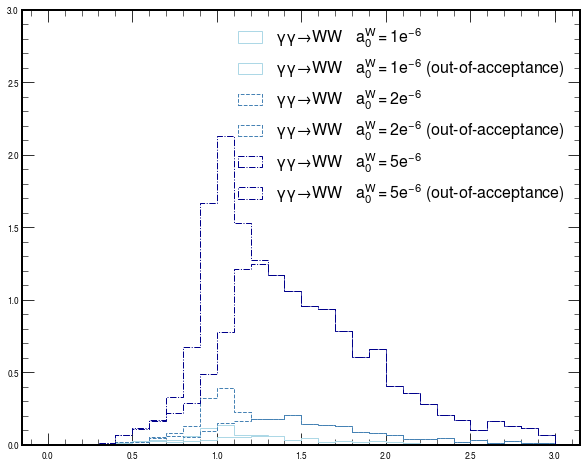

In [67]:
label_ = "GGToWW-AQGC-A0W5e-6"

fig = plt.figure( figsize=(10,8) )

colors_ = [ "lightblue", "steelblue", "darkblue" ]
linestyles_ = [ "-", "--", "-." ]
for idx_, label_ in enumerate( labels_signals ):
    plt.hist( df_signals_protons_multiRP_sig_plus_mix_2protons_selected_events[ label_ ][ "ratioMWW_MX" ], weights=weights_sig_plus_mix_2protons[ label_ ],
              histtype='step', color=colors_[ idx_ ], linestyle=linestyles_[ idx_ ], label=labels_samples[ label_ ],
              bins=30, range=(0.,3.) )
    plt.hist( df_signals_protons_multiRP_sig_plus_mix_selected_events_categories_concat_skip_sig[ label_ ][ "ratioMWW_MX" ], weights=weights_sig_plus_mix_categories_concat_skip_sig[ label_ ],
              histtype='step', color=colors_[ idx_ ], linestyle=linestyles_[ idx_ ], label=( labels_samples[ label_ ] + " (out-of-acceptance)" ),
              bins=30, range=(0.,3.) )
plt.legend( loc='best', fontsize=16 )
    
plt.ylim( (0.,3.) )

if save_figures:
    plt.savefig( "plots/Ratio_MWW_MX_signals_mix.pdf", bbox_inches='tight' )
    plt.savefig( "plots/Ratio_MWW_MX_signals_mix.png", bbox_inches='tight' )

2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix


(0.0, 3.0)

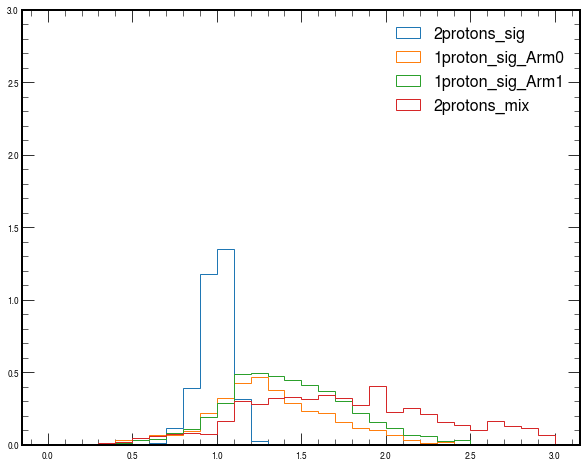

In [68]:
# label_ = "GGToWW-AQGC-A0W5e-6"

fig = plt.figure( figsize=(10,8) )
for key_ in df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ]:
    print ( key_ )
    df_selected_events__ = df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ key_ ]
    plt.hist( df_selected_events__[ "ratioMWW_MX" ], weights=weights_sig_plus_mix_categories[ label_ ][ key_ ],
              histtype='step', label=key_,
              bins=30, range=(0.,3.) )
plt.legend( loc='best', fontsize=16 )
plt.ylim( (0.,3.) )

2protons_sig
1proton_sig_Arm0
1proton_sig_Arm1
2protons_mix


(0.0, 3.0)

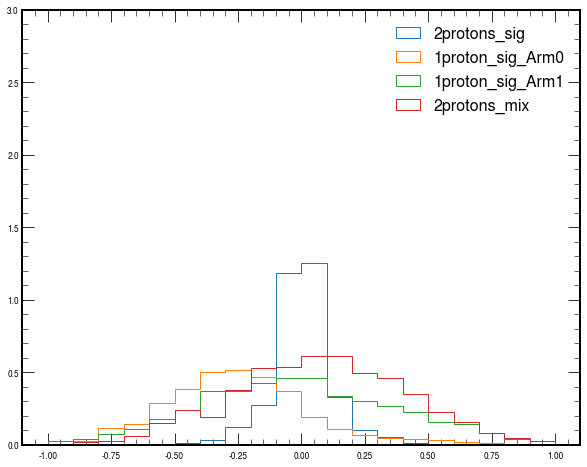

In [69]:
# label_ = "GGToWW-AQGC-A0W5e-6"

fig = plt.figure( figsize=(10,8) )
for key_ in df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ]:
    print ( key_ )
    df_selected_events__ = df_signals_protons_multiRP_sig_plus_mix_selected_events_categories[ label_ ][ key_ ]
    plt.hist( df_selected_events__[ "diffYWW_YX" ], weights=weights_sig_plus_mix_categories[ label_ ][ key_ ],
              histtype='step', label=key_,
              bins=20, range=(-1.,1.) )
plt.legend( loc='best', fontsize=16 )
plt.ylim( (0.,3.) )

In [70]:
# label_ = "GGToWW-AQGC-A0W5e-6"
# fig = plt.figure( figsize=(12,10) )
# for key_ in df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ]:
#     print ( key_ )
#     df_selected_events__ = df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events[ label_ ][ key_ ]
#     plt.hist( df_selected_events__[ "ratioMWW_MX" ], weights=weights_out_acceptance_misreconstructed[ label_ ][ key_ ],
#               histtype='step', label=key_,
#               bins=20, range=(0.,2.) )
# plt.legend( loc='best', fontsize=16 )

In [71]:
# fig = plt.figure( figsize=(10,8) )

# colors_ = [ "lightblue", "steelblue", "darkblue" ]
# linestyles_ = [ "-", "--", "-." ]
# for idx_, label_ in enumerate( labels_signals ):
#     plt.hist( df_signals_protons_multiRP_events[ label_ ][ "ratioMWW_MX" ], weights=weights_mc[ label_ ],
#               histtype='step', color=colors_[ idx_ ], linestyle=linestyles_[ idx_ ], label=labels_samples[ label_ ],
#               bins=30, range=(0.,3.) )
#     plt.hist( df_signals_protons_multiRP_out_acceptance_misreconstructed_selected_events_concat[ label_ ][ "ratioMWW_MX" ],
#               weights=weights_out_acceptance_misreconstructed_concat[ label_ ],
#               histtype='step', color=colors_[ idx_ ], linestyle=linestyles_[ idx_ ], label=( labels_samples[ label_ ] + " (out-of-acceptance)" ),
#               bins=30, range=(0.,3.) )


# plt.legend( loc='best', fontsize=16 )
    
# plt.ylim( (0.,3.) )

# if save_figures:
#     plt.savefig( "plots/Ratio_MWW_MX_signals.pdf", bbox_inches='tight' )
#     plt.savefig( "plots/Ratio_MWW_MX_signals.png", bbox_inches='tight' )